# Refine Positive genes

Gaol: postive gesn form tpevios stesp are too broad, a methodd to reifne them is needed.

Idea: 
- find cells in the cycicling prcess
    - use geneset scores to find thme
- use rpevius psotive genes set asa progrma and find if these ghenes are expressed ....

In [16]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import ast
from matplotlib_venn import venn2
from statsmodels.stats.multitest import multipletests
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load scrna datset

In [17]:
data_dir = config["data_paths"]["neftel_data_folder"]

# Load the matrix (Cell by Gene, or Gene by Cell, default is usually gene x cell)
adata = sc.read_mtx(os.path.join(data_dir, 'Exp_data_UMIcounts.mtx')).T # Transpose to get Cell x Gene

# Read feature names (genes) and barcodes (cells)
genes = pd.read_csv(os.path.join(data_dir, 'Genes.txt'), header=None, names=["gene"], sep='\t')
display(genes.head(2))
cells = pd.read_csv(os.path.join(data_dir, 'Cells.csv'), index_col=0)
display(cells.head(2))

# Assign gene names
adata.var_names = genes.gene.astype(str)

# Add cell metadata and ensure obs_names are strings
adata.obs = cells
adata.obs_names = adata.obs.index.astype(str)

print("Data Loaded:")
display(adata.obs)
display(adata.obs.columns)

# check data structure
X = adata.X.toarray()
print("Is data raw of log normalised?")
print("min, max", np.min(adata.X), np.max(adata.X))
print(X[X > 0][:20]) 
print("Has gene ecpression been centered?")
gene_means = np.array(X.mean(axis=0)).ravel()
print("Mean expression per gene (first 10):", gene_means[:10])
print("Overall mean of gene means:", gene_means.mean())

gene
0  FAM138A
1    OR4F5

sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                              
102_1        102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2        102  Malignant        2366 -12.6327 -18.9353     1.1051   

           g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                
102_1         0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2         0.2308             G1/S        1.4424  Cell Cycle - G1/S   

               mp_assignment  
cell_name                     
102_1       Oligo Progenitor  
102_2      Cell Cycle - G1/S

Data Loaded:


sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                               
102_1         102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2         102  Malignant        2366 -12.6327 -18.9353     1.1051   
102_4         102  Malignant        1217 -11.9102 -18.0864    -0.1774   
102_5         102  Malignant        2285  20.1392 -11.5944    -0.1211   
102_7         102  Malignant        1725  17.2946 -16.4965    -0.0337   
...           ...        ...         ...      ...      ...        ...   
105_D2_211    105        NaN         451      NaN      NaN        NaN   
105_D2_212    105  Malignant         506      NaN      NaN        NaN   
105_D2_213    105        NaN         680      NaN      NaN        NaN   
105_D2_214    105  Malignant         622      NaN      NaN        NaN   
105_D2_216    105  Malignant         616      NaN      NaN        NaN   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_1          0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_4         -0.0561      Not cycling        1.4340             Stress   
102_5         -0.0473      Not cycling        2.6042   Oligo Progenitor   
102_7         -0.0467      Not cycling        1.5445         NPC Glioma   
...               ...              ...           ...                ...   
105_D2_211        NaN              NaN           NaN                NaN   
105_D2_212        NaN              NaN           NaN                NaN   
105_D2_213        NaN              NaN           NaN                NaN   
105_D2_214        NaN              NaN           NaN                NaN   
105_D2_216        NaN              NaN           NaN                NaN   

                mp_assignment  
cell_name                      
102_1        Oligo Progenitor  
102_2       Cell Cycle - G1/S  
102_4                     NaN  
102_5        Oligo Progenitor  
102_7              NPC Glioma  
...                       ...  
105_D2_211                NaN  
105_D2_212                NaN  
105_D2_213                NaN  
105_D2_214                NaN  
105_D2_216                NaN  

[16201 rows x 11 columns]

Index(['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score',
       'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top',
       'mp_assignment'],
      dtype='object')

Is data raw of log normalised?
min, max 0.0 9814.0
[2. 1. 2. 2. 3. 1. 1. 1. 1. 1. 4. 1. 1. 2. 2. 3. 4. 4. 1. 4.]
Has gene ecpression been centered?
Mean expression per gene (first 10): [0.0000000e+00 0.0000000e+00 2.6541571e-03 6.1724582e-05 0.0000000e+00
 6.1724582e-05 3.3516449e-01 6.9131535e-03 0.0000000e+00 0.0000000e+00]
Overall mean of gene means: 0.30058536


## Simple Preprocessing

- make genes names unique
- remove cell wiht no cell pahse label
- remove cell wiht to low genes, too mamy genes, to high mt score
- remove geens wiht too low cells
- normalise
- log transfoer
- do NOT scale/center !!!

Are genes unique? True


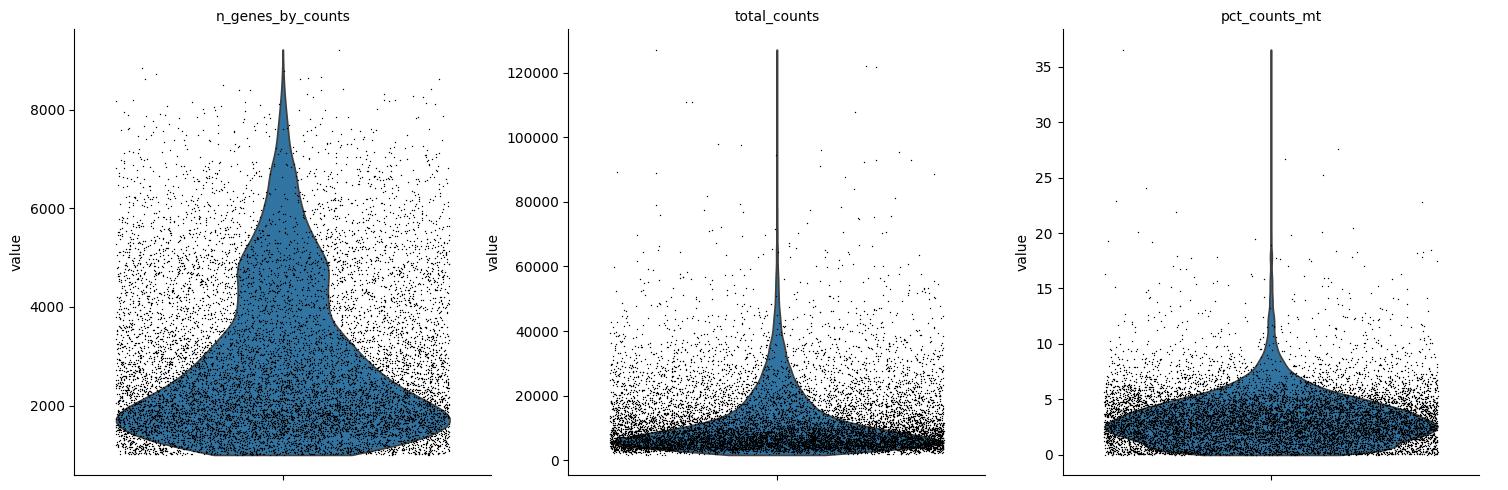

After cell filtering: 10678 cells remain.
After gene filtering: 20740 genes remain.


In [18]:
###############

# ATTENTION: makes genes unqiuie
adata.var_names_make_unique()
print("Are genes unique?", adata.var_names.is_unique)

# ATTETION: remove cells wiht at least 1 None in metadata
adata = adata[~adata.obs[["cell_cycle_phase"]].isna().any(axis=1)].copy()

###############

# Identify mitochondrial genes (human: 'MT-', mouse: 'mt-')
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))

# Compute per-cell QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)

#
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

# Filter cells ---
min_genes = 200           # drop low-quality cells
max_genes = 6000          # drop likely doublets
max_mito  = 10            # drop cells with >10% mitochondrial reads

adata = adata[
    (adata.obs["n_genes_by_counts"] > min_genes)
    & (adata.obs["n_genes_by_counts"] < max_genes)
    & (adata.obs["pct_counts_mt"] < max_mito),
].copy()

print(f"After cell filtering: {adata.n_obs} cells remain.")

# Filter genes ---
# Keep genes expressed in at least min_cells cells
min_cells = 5
sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"After gene filtering: {adata.n_vars} genes remain.")

# Normalize per cell (to make library sizes comparable)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform (compress the dynamic range)
sc.pp.log1p(adata)

# Store the normalized data for downstream analysis
adata.raw = adata

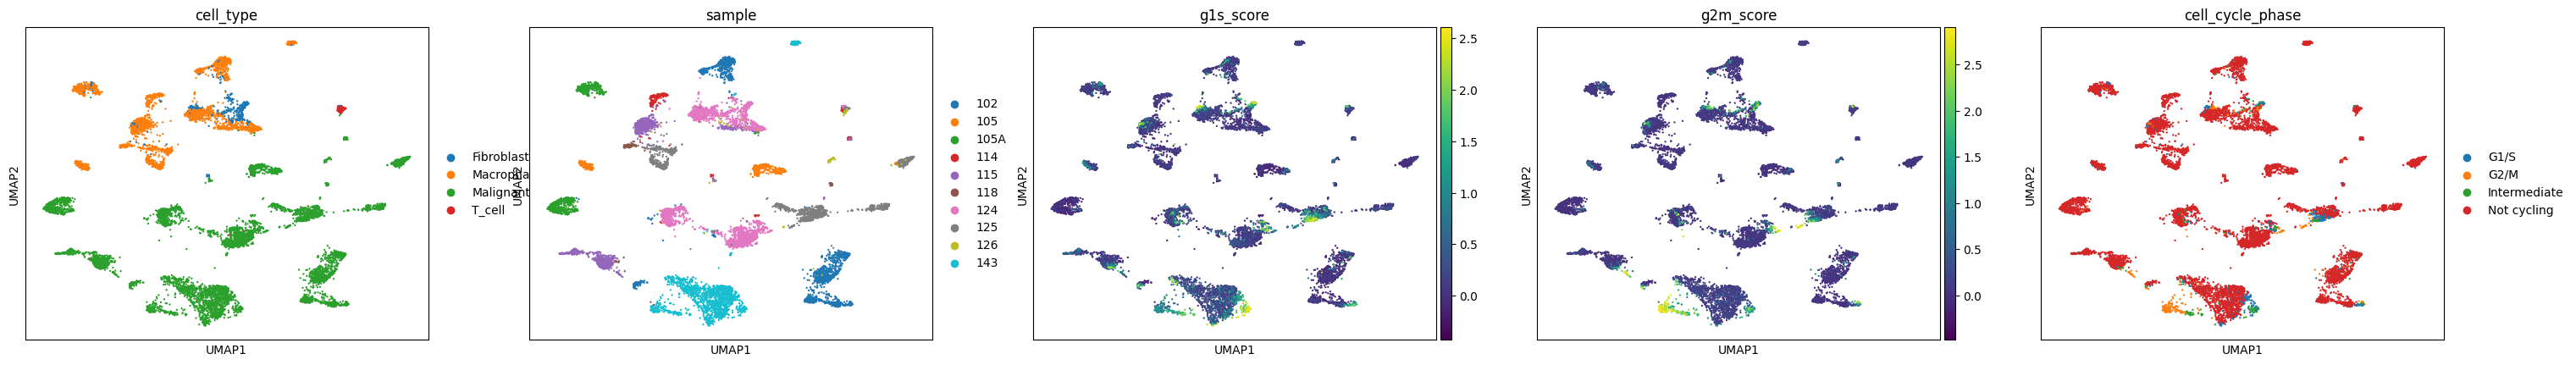

In [19]:
# plot umap
umap_data_array = adata.obs[['umap1', 'umap2']].values
adata.obsm['umap'] = umap_data_array

sc.pl.embedding(adata, basis="umap", color=["cell_type", "sample", "g1s_score", "g2m_score", "cell_cycle_phase"], ncols=5)


In [20]:
# Get top N highly expressed genes
n_top = 7000

# Calculate mean expression per gene
mean_expression_per_gene = adata.X.mean(axis=0)
if hasattr(mean_expression_per_gene, 'A1'):
    mean_expression_per_gene = mean_expression_per_gene.A1

# Get indices of top N genes
top_n_indices = np.argsort(mean_expression_per_gene)[-n_top:][::-1]  # Descending order
top_n_genes = adata.var_names[top_n_indices]

print(f"Top {n_top} highly expressed genes:")
print(top_n_genes.tolist())

Top 7000 highly expressed genes:
['MALAT1', 'TMSB4X', 'FTH1', 'FTL', 'ACTB', 'MT-CO1', 'TMSB10', 'B2M', 'GAPDH', 'RPS19', 'RPL10', 'MT-CO3', 'RPLP1', 'RPS18', 'MT-CO2', 'MT-ND4', 'RPS2', 'RPL13', 'RPS15', 'RPL13A', 'RPL32', 'RPS14', 'RPLP2', 'RPL11', 'RPL15', 'PTMA', 'RPS27A', 'H3F3B', 'RPL19', 'MT-ND2', 'EIF1', 'RPS4X', 'RPL41', 'RPL34', 'RPL8', 'RPL28', 'RPL37A', 'ACTG1', 'TPT1', 'RPL26', 'MT-CYB', 'RPL27A', 'RPS15A', 'RPS6', 'RPL23A', 'RPS8', 'RPL36', 'RPS12', 'RPS23', 'MT-ND1', 'EEF1A1', 'RPL35', 'RPS3', 'RPS9', 'CFL1', 'RPS13', 'RPL12', 'FAU', 'RPS16', 'RPL35A', 'RPL30', 'RPL29', 'RPL18', 'RPS5', 'RPL18A', 'RPL3', 'GNB2L1', 'TUBA1A', 'MT-ATP6', 'RPS28', 'UBA52', 'RPL31', 'RPS25', 'RPS7', 'MYL6', 'UBC', 'RPL6', 'CD63', 'RPS27', 'SPP1', 'RPS3A', 'RPS20', 'RPS24', 'RPS11', 'RPLP0', 'RPL14', 'RPL10A', 'RPL27', 'RPS29', 'OAZ1', 'HLA-A', 'RPL21', 'HSP90AA1', 'TUBA1B', 'UBB', 'RPL7A', 'HLA-B', 'ATP5E', 'CALM2', 'RPL38', 'RPL37', 'SEC61G', 'RPL24', 'NACA', 'RPL5', 'CST3', 'SERF2', 'RPL7',

# Load precalculated putative positive genes

In [21]:
positive_genes_df = pd.read_csv(config["data_paths"]["broad_positive_genes"])
positive_genes_df = positive_genes_df.sort_values(by="geneset_count", ascending=False)
display(positive_genes_df)

broad_positive_gene_list = positive_genes_df[positive_genes_df.label == "positive"].gene.to_list()
print("positive genes", len(broad_positive_gene_list))

high_prevalence_broad_positive_gene_list = positive_genes_df[positive_genes_df.label == "positive"].gene[:100].to_list()
print("High prevalencepositive genes", len(high_prevalence_broad_positive_gene_list))

gene  geneset_count  is_guaranteed     label  geneset_percent
2      H2AFZ             98           True  positive        33.676976
6     MLF1IP             98           True  positive        33.676976
1     FAM64A             98           True  positive        33.676976
0       CDK1             98           True  positive        33.676976
4        HN1             98           True  positive        33.676976
...      ...            ...            ...       ...              ...
7278  ZNF782              1          False  ambigous         0.343643
7277  ZNF771              1          False  ambigous         0.343643
7276  ZNF768              1          False  ambigous         0.343643
7275  ZNF766              1          False  ambigous         0.343643
7274  ZNF764              1          False  ambigous         0.343643

[7294 rows x 5 columns]

positive genes 1148
High prevalencepositive genes 100


# Optional: verify cell phase precimputed labels

Find which cells are in the cell cycle process:
- adata alredy contains this info
- just to be sure recalcuate, how?
    - take genesets related to cell cycle
    - claulte module

['Not cycling', 'G1/S', 'G2/M', 'Intermediate']
Categories (4, object): ['G1/S', 'G2/M', 'Intermediate', 'Not cycling']

MP1 Cell Cycle - G2/M MP2 Cell Cycle - G1/S MP3 Cell Cylce HMG-rich  \
0                 HMGB2                  PCNA                   STMN1   
1                 UBE2C                  FEN1                  TUBA1B   

  MP4 Chromatin MP5 Cell cycle single-nucleus MP6 Stress 1 MP7 Hypoxia  \
0        GOLGB1                         ATAD2         EGR1       NDRG1   
1         ASH1L                         BRCA1          FOS       BNIP3   

  MP8 Stress (in vitro) MP9 Stress 2 MP10 Proteasomal degradation  ...  \
0                 DDIT3        HSPH1                         CCT5  ...   
1                SLC3A2       HSPA1A                         CCT7  ...   

  MP58 Metal-response MP59 PDAC-related 1 MP60 PDAC-related 2  \
0               DDIT4             CEACAM6               PLAUR   
1                MT1E               S100P                UPP1   

  MP61 PDAC-related 3 MP62 PDAC-related 4 MP63 PDAC-related 5 MP64 Adherens  \
0                GPX2                  CP               NEAT1        DHCR24   
1              ANXA10                MMP7                AGRN          JAG1   

  MP65 Cholesterol Homeostasis MP66 Unassigned 1 MP67 Unassigned 2  
0                         SQLE        AC010343.1             CCNL2  
1                       HMGCS1             AKAP9          CDK5RAP3  

[2 rows x 67 columns]

sample   cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                                
102_1         102   Malignant        3101  20.8435 -12.0361    -0.0434   
102_2         102   Malignant        2366 -12.6327 -18.9353     1.1051   
102_4         102   Malignant        1217 -11.9102 -18.0864    -0.1774   
102_7         102   Malignant        1725  17.2946 -16.4965    -0.0337   
102_8         102   Malignant        2252  17.3138 -16.9457     0.0078   
...           ...         ...         ...      ...      ...        ...   
105_D2_139    105   Malignant        1029  28.8941   9.4308    -0.2548   
105_D2_148    105   Malignant        1035  29.0623   9.6065    -0.2660   
105_D2_189    105  Macrophage        1126 -20.2338   8.0329    -0.0252   
105_D2_190    105  Macrophage        1138 -20.1501   8.1597     0.1114   
105_D2_207    105  Macrophage        1137 -20.0538   8.1416    -0.0508   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_1          0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_4         -0.0561      Not cycling        1.4340             Stress   
102_7         -0.0467      Not cycling        1.5445         NPC Glioma   
102_8         -0.0566      Not cycling        1.0364         NPC Glioma   
...               ...              ...           ...                ...   
105_D2_139    -0.0581      Not cycling        4.9770       Oligo normal   
105_D2_148    -0.0584      Not cycling        5.2820       Oligo normal   
105_D2_189     0.0550      Not cycling        1.0727               MAC3   
105_D2_190     0.0570      Not cycling        1.4108  Monocyte/Secreted   
105_D2_207    -0.0167      Not cycling        1.4494               MAC3   

                mp_assignment  n_genes_by_counts  total_counts  \
cell_name                                                        
102_1        Oligo Progenitor               3113       11446.0   
102_2       Cell Cycle - G1/S               2374        6273.0   
102_4                     NaN               1220        2867.0   
102_7              NPC Glioma               1732        4911.0   
102_8              NPC Glioma               2263        6541.0   
...                       ...                ...           ...   
105_D2_139                NaN               1045        7953.0   
105_D2_148                NaN               1047        8796.0   
105_D2_189               MAC3               1136       13710.0   
105_D2_190                NaN               1152       26001.0   
105_D2_207               MAC3               1149       14057.0   

            total_counts_mt  pct_counts_mt  G2_M_score  G1_S_score  cc_score  
cell_name                                                                     
102_1                 872.0       7.618382   -0.124465   -0.229956 -0.178966  
102_2                 165.0       2.630320    0.211156    0.364106  0.308053  
102_4                  64.0       2.232299   -0.046391   -0.156796 -0.092250  
102_7                 292.0       5.945836    0.006268   -0.091275 -0.032307  
102_8                 193.0       2.950619    0.039423   -0.063056 -0.025039  
...                     ...            ...         ...         ...       ...  
105_D2_139            103.0       1.295109    0.103201   -0.082252  0.017454  
105_D2_148            221.0       2.512506    0.033960   -0.019480 -0.009940  
105_D2_189            199.0       1.451495    0.031664   -0.102325 -0.030288  
105_D2_190            598.0       2.299911    0.001422   -0.107084 -0.047092  
105_D2_207            313.0       2.226649    0.002820   -0.106820 -0.047874  

[10678 rows x 18 columns]

cc_score  G1_S_score  G2_M_score  g1s_score  g2m_score
cc_score    1.000000    0.858986    0.955390   0.744471   0.835541
G1_S_score  0.858986    1.000000    0.673008   0.873053   0.538574
G2_M_score  0.955390    0.673008    1.000000   0.578969   0.904341
g1s_score   0.744471    0.873053    0.578969   1.000000   0.582209
g2m_score   0.835541    0.538574    0.904341   0.582209   1.000000

<Axes: ylabel='Frequency'>

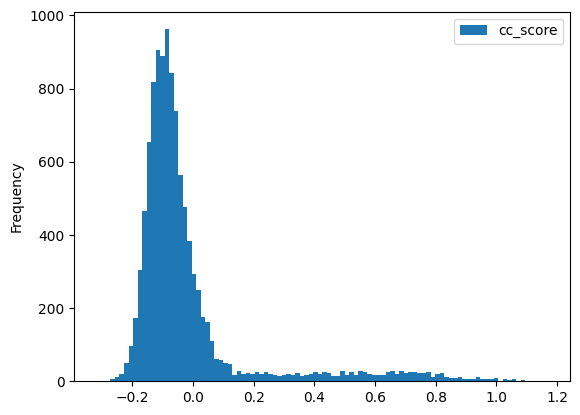

In [22]:
# sho what cell cyel ingo is alredy present
display(adata.obs.cell_cycle_phase.unique())

# read VERY spefiic gene set for ccylcing cells
metaprograms_df = pd.read_excel(config["data_paths"]["metaprograms_3CA"])
display(metaprograms_df.head(2))

strict_G2_M_genes = set(metaprograms_df["MP1 Cell Cycle - G2/M"])
strict_G1_S_genes = set(metaprograms_df["MP2 Cell Cycle - G1/S"])
strict_cc_genes = strict_G2_M_genes.union(strict_G1_S_genes)
len(strict_cc_genes)

# calculate module for each cell
ctrl_size=10
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_G2_M_genes),
    ctrl_size=ctrl_size, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="G2_M_score"
)
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_G1_S_genes),
    ctrl_size=ctrl_size, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="G1_S_score"
)
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_cc_genes),
    ctrl_size=ctrl_size, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="cc_score"
)

display(adata.obs)

# chekc if new scores correlate wiht old ones
display(adata.obs[["cc_score", "G1_S_score", "G2_M_score", "g1s_score", "g2m_score"]].corr())
adata.obs[["cc_score"]].plot(kind="hist", bins=100)

# Analyse Cycling Vs Non Cycling

In [23]:
adata_cycling = adata[
    (adata.obs["cell_cycle_phase"] != "Intermediate") &

    # ATTENTION
    (adata.obs["sample"] == "143") & # for single patinet (143 has most cells)

    (adata.obs["cell_type"] == "Malignant") #like in apper https://www.weizmann.ac.il/sites/3CA/study-data/cell-cycle/20099
    ].copy()

# ATTNETION: Remove genes with zero/low variance
# LATER: After subsampling

# Add label
adata_cycling.obs["phase"] = np.where(
    adata_cycling.obs["cell_cycle_phase"].isin(["G1/S", "G2/M"]), 
    "Cycling", 
    "Not cycling"
)

print("Cycling cells:", adata_cycling.obs["phase"].value_counts())

Cycling cells: phase
Not cycling    1180
Cycling         297
Name: count, dtype: int64


In [24]:
# subsaple cells fro fatser testing
adata_cycling.obs["cell_name"] = adata_cycling.obs_names
SAMPLE_N = 200
subsampled_ids = adata_cycling.obs.groupby('phase').apply(lambda x: x.sample(n=SAMPLE_N, random_state=42)).cell_name.to_list()

# subsamplòe
adata_cycling_subsampled = adata_cycling[subsampled_ids].copy()

# VARIANCE: rmeove gens with zero variance
gene_variances = np.var(adata_cycling_subsampled.X.toarray(), axis=0)
adata_cycling_subsampled = adata_cycling_subsampled[:, gene_variances > 1e-6].copy()

# Sort by phase
adata_cycling_subsampled = adata_cycling_subsampled[adata_cycling_subsampled.obs['phase'].sort_values().index]

adata_cycling_subsampled

/tmp/ipykernel_3465/1994160895.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_ids = adata_cycling.obs.groupby('phase').apply(lambda x: x.sample(n=SAMPLE_N, random_state=42)).cell_name.to_list()


View of AnnData object with n_obs × n_vars = 400 × 16887
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'G2_M_score', 'G1_S_score', 'cc_score', 'phase', 'cell_name'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'cell_type_colors', 'sample_colors', 'cell_cycle_phase_colors'
    obsm: 'umap'

In [25]:
# Select postive genes in adata
broad_positive_gene_list_in_adata = [g for g in broad_positive_gene_list if g in adata_cycling_subsampled.var_names]
high_prevalence_broad_positive_gene_list_in_adata = [g for g in high_prevalence_broad_positive_gene_list if g in adata_cycling_subsampled.var_names]
top_expressed_genes_in_adata = [g for g in top_n_genes if g in adata_cycling_subsampled.var_names]
broad_positive_gene_missing = set(broad_positive_gene_list).difference(broad_positive_gene_list_in_adata)
print("Broad postive genes:", len(broad_positive_gene_list))
print("Broad postive genes in adata:", len(broad_positive_gene_list_in_adata))
print("High prevalence broad postive genes in adata:", len(high_prevalence_broad_positive_gene_list_in_adata))
print("High prevalence broad postive genes in adata:", len(top_expressed_genes_in_adata))

print("Missing genes:", len(broad_positive_gene_missing), broad_positive_gene_missing)

Broad postive genes: 1148
Broad postive genes in adata: 992
High prevalence broad postive genes in adata: 97
High prevalence broad postive genes in adata: 6937
Missing genes: 156 {'H2BC3', 'FAM107A', 'TUBA3E', 'OR2A4', 'GPR15LG', 'MIR208A', 'MLF1IP', 'HOXA13', 'TGFA', 'DUX4', 'CCNQ', 'H4C5', 'CEP43', 'JPT1', 'CENPS', 'NOP53', 'KNL1', 'NEUROG1', 'MAPK15', 'SEM1', 'CEP131', 'MIR16-1', 'INS', 'MIR193A', 'MIR137', 'TM4SF5', 'H4C12', 'BTC', 'FGF8', 'TCIM', 'PSMA2', 'TUBA3D', 'MIR221', 'H2BC4', 'CASP8AP2', 'TUBB1', 'TFDP3', 'KIF25', 'MIR362', 'H2BC21', 'MIR520H', 'MIR222', 'HORMAD1', 'MIR892B', 'H4C8', 'CD28', 'H4C2', 'CCNB3', 'BABAM2', 'MIR515-1', 'GFI1B', 'H2BC9', 'MIR495', 'IL1A', 'KCNA5', 'H2AC20', 'PCLAF', 'CEP295', 'SLFN11', 'PKHD1', 'H4C14', 'TUBA3C', 'NANOGP8', 'INTS13', 'MIR15A', 'TUBB8', 'MIR424', 'MIR372', 'CHMP4BP1', 'H2BC7', 'H2AX', 'MRNIP', 'H2AZ2', 'WNT10B', 'MACROH2A1', 'RFPL1', 'MIR133A1', 'MRE11', 'PRKCB', 'UHRF1', 'PLCG2', 'MIR133B', 'H4C1', 'MIR195', 'NSD2', 'EPGN', 'MIR2

###  All malignant cells
- cell-cell correlation matrix (all HQ genes)
- cell-cell correlation (1000 pos genes)
- cell-cell correlation (100 pos genes)
- 
- clustermap correlation (1000 pos genes)
- clustermap correlation (100 pos genes)

cell_name    143_7d_1258  143_7d_962  143_7d_1442  143_7d_867  143_7d_1250  \
cell_name                                                                    
143_7d_1258     1.000000    0.752972     0.688409    0.746599     0.766188   
143_7d_962      0.752972    1.000000     0.708365    0.796644     0.806048   
143_7d_1442     0.688409    0.708365     1.000000    0.715660     0.720339   
143_7d_867      0.746599    0.796644     0.715660    1.000000     0.803180   
143_7d_1250     0.766188    0.806048     0.720339    0.803180     1.000000   
...                  ...         ...          ...         ...          ...   
143_7d_1106     0.709386    0.759812     0.689206    0.758600     0.752616   
143_7d_798      0.739442    0.792198     0.706865    0.798724     0.804258   
143_7d_1710     0.580361    0.629649     0.585369    0.621334     0.635761   
143_7d_1959     0.726829    0.776095     0.693584    0.780289     0.766615   
143_7d_1292     0.696393    0.764653     0.674059    0.764541     0.760459   

cell_name    143_7d_889  143_7d_2090  143_7d_2049  143_7d_1140  143_7d_1351  \
cell_name                                                                     
143_7d_1258    0.800832     0.722974     0.684983     0.767504     0.760069   
143_7d_962     0.806401     0.778720     0.722691     0.806615     0.814278   
143_7d_1442    0.757322     0.685879     0.634297     0.717962     0.724563   
143_7d_867     0.806976     0.774591     0.729258     0.803497     0.795454   
143_7d_1250    0.812354     0.778488     0.726154     0.810920     0.791954   
...                 ...          ...          ...          ...          ...   
143_7d_1106    0.761315     0.734105     0.670614     0.752461     0.792940   
143_7d_798     0.790606     0.790652     0.716717     0.794056     0.795168   
143_7d_1710    0.623844     0.625639     0.550615     0.622428     0.621821   
143_7d_1959    0.789011     0.748306     0.690602     0.772836     0.817268   
143_7d_1292    0.758636     0.747965     0.684395     0.762192     0.760422   

cell_name    ...  143_7d_2279  143_7d_182  143_7d_1738  143_7d_326  \
cell_name    ...                                                     
143_7d_1258  ...     0.702152    0.685906     0.718440    0.683352   
143_7d_962   ...     0.770006    0.753641     0.758839    0.745881   
143_7d_1442  ...     0.674574    0.670145     0.683250    0.698970   
143_7d_867   ...     0.767190    0.768489     0.747840    0.751883   
143_7d_1250  ...     0.769117    0.745663     0.751931    0.753508   
...          ...          ...         ...          ...         ...   
143_7d_1106  ...     0.742004    0.725396     0.752041    0.733615   
143_7d_798   ...     0.790857    0.767559     0.750080    0.754616   
143_7d_1710  ...     0.626829    0.605232     0.587102    0.613269   
143_7d_1959  ...     0.761696    0.753224     0.762069    0.742450   
143_7d_1292  ...     0.751215    0.748525     0.715904    0.734907   

cell_name    143_7d_799  143_7d_1106  143_7d_798  143_7d_1710  143_7d_1959  \
cell_name                                                                    
143_7d_1258    0.710812     0.709386    0.739442     0.580361     0.726829   
143_7d_962     0.756236     0.759812    0.792198     0.629649     0.776095   
143_7d_1442    0.687373     0.689206    0.706865     0.585369     0.693584   
143_7d_867     0.754952     0.758600    0.798724     0.621334     0.780289   
143_7d_1250    0.756611     0.752616    0.804258     0.635761     0.766615   
...                 ...          ...         ...          ...          ...   
143_7d_1106    0.729748     1.000000    0.755415     0.610702     0.780301   
143_7d_798     0.763992     0.755415    1.000000     0.641385     0.765941   
143_7d_1710    0.594622     0.610702    0.641385     1.000000     0.612841   
143_7d_1959    0.766258     0.780301    0.765941     0.612841     1.000000   
143_7d_1292    0.747519     0.735878    0.778031     0.608551     0.752521   

cell_name    143_7d_1292  
cell

cell_name    143_7d_1258  143_7d_962  143_7d_1442  143_7d_867  143_7d_1250  \
cell_name                                                                    
143_7d_1258     1.000000    0.726082     0.647548    0.720531     0.739603   
143_7d_962      0.726082    1.000000     0.669609    0.773024     0.782859   
143_7d_1442     0.647548    0.669609     1.000000    0.681610     0.682323   
143_7d_867      0.720531    0.773024     0.681610    1.000000     0.781213   
143_7d_1250     0.739603    0.782859     0.682323    0.781213     1.000000   
...                  ...         ...          ...         ...          ...   
143_7d_1106     0.678013    0.732969     0.654360    0.733933     0.720716   
143_7d_798      0.709755    0.763235     0.666510    0.775131     0.779331   
143_7d_1710     0.527533    0.579519     0.538590    0.573752     0.585493   
143_7d_1959     0.696971    0.749412     0.655207    0.754702     0.734607   
143_7d_1292     0.660442    0.735976     0.631831    0.739031     0.729968   

cell_name    143_7d_889  143_7d_2090  143_7d_2049  143_7d_1140  143_7d_1351  \
cell_name                                                                     
143_7d_1258    0.782575     0.693629     0.660153     0.745909     0.733610   
143_7d_962     0.783136     0.753339     0.700559     0.787191     0.791405   
143_7d_1442    0.725139     0.648794     0.598098     0.683654     0.688563   
143_7d_867     0.786035     0.749573     0.707049     0.785238     0.771340   
143_7d_1250    0.790013     0.755467     0.704500     0.790978     0.761448   
...                 ...          ...          ...          ...          ...   
143_7d_1106    0.733556     0.707203     0.643691     0.727849     0.772668   
143_7d_798     0.764197     0.772184     0.692748     0.771946     0.767829   
143_7d_1710    0.572623     0.582661     0.504641     0.576197     0.570022   
143_7d_1959    0.763966     0.723291     0.664722     0.748557     0.799334   
143_7d_1292    0.729539     0.724356     0.656916     0.739453     0.730459   

cell_name    ...  143_7d_2279  143_7d_182  143_7d_1738  143_7d_326  \
cell_name    ...                                                     
143_7d_1258  ...     0.667660    0.650943     0.687928    0.643877   
143_7d_962   ...     0.745627    0.728164     0.725895    0.713943   
143_7d_1442  ...     0.633357    0.632396     0.642700    0.666652   
143_7d_867   ...     0.742769    0.746631     0.714042    0.724444   
143_7d_1250  ...     0.741299    0.715997     0.715400    0.725189   
...          ...          ...         ...          ...         ...   
143_7d_1106  ...     0.714375    0.697481     0.726976    0.706677   
143_7d_798   ...     0.769763    0.745369     0.713847    0.725473   
143_7d_1710  ...     0.584619    0.563648     0.531936    0.570004   
143_7d_1959  ...     0.736878    0.730046     0.733647    0.712417   
143_7d_1292  ...     0.725784    0.725742     0.677624    0.706954   

cell_name    143_7d_799  143_7d_1106  143_7d_798  143_7d_1710  143_7d_1959  \
cell_name                                                                    
143_7d_1258    0.681695     0.678013    0.709755     0.527533     0.696971   
143_7d_962     0.731097     0.732969    0.763235     0.579519     0.749412   
143_7d_1442    0.652679     0.654360    0.666510     0.538590     0.655207   
143_7d_867     0.731085     0.733933    0.775131     0.573752     0.754702   
143_7d_1250    0.729448     0.720716    0.779331     0.585493     0.734607   
...                 ...          ...         ...          ...          ...   
143_7d_1106    0.703865     1.000000    0.725389     0.565724     0.763400   
143_7d_798     0.740149     0.725389    1.000000     0.597468     0.735098   
143_7d_1710    0.547244     0.565724    0.597468     1.000000     0.563868   
143_7d_1959    0.746980     0.763400    0.735098     0.563868     1.000000   
143_7d_1292    0.725589     0.708702    0.753683     0.562229     0.724880   

cell_name    143_7d_1292  
cell

cell_name    143_7d_1258  143_7d_962  143_7d_1442  143_7d_867  143_7d_1250  \
cell_name                                                                    
143_7d_1258     1.000000    0.654516     0.610713    0.657865     0.708576   
143_7d_962      0.654516    1.000000     0.579649    0.781219     0.803095   
143_7d_1442     0.610713    0.579649     1.000000    0.613026     0.616351   
143_7d_867      0.657865    0.781219     0.613026    1.000000     0.787696   
143_7d_1250     0.708576    0.803095     0.616351    0.787696     1.000000   
...                  ...         ...          ...         ...          ...   
143_7d_1106     0.609066    0.771702     0.587729    0.746345     0.769981   
143_7d_798      0.620736    0.755701     0.579893    0.762079     0.757866   
143_7d_1710     0.490455    0.632274     0.445051    0.593287     0.600314   
143_7d_1959     0.635758    0.766200     0.569845    0.761240     0.751141   
143_7d_1292     0.603723    0.761411     0.562435    0.741632     0.759821   

cell_name    143_7d_889  143_7d_2090  143_7d_2049  143_7d_1140  143_7d_1351  \
cell_name                                                                     
143_7d_1258    0.779676     0.652827     0.641317     0.717919     0.684474   
143_7d_962     0.705787     0.734876     0.692182     0.775031     0.771815   
143_7d_1442    0.733662     0.572153     0.535105     0.597627     0.586592   
143_7d_867     0.728220     0.741826     0.714228     0.782887     0.757583   
143_7d_1250    0.727762     0.760732     0.702404     0.791986     0.761769   
...                 ...          ...          ...          ...          ...   
143_7d_1106    0.672781     0.716287     0.663792     0.704471     0.746732   
143_7d_798     0.671537     0.761399     0.654022     0.731248     0.784112   
143_7d_1710    0.507191     0.583605     0.499455     0.558643     0.627996   
143_7d_1959    0.688674     0.716121     0.640777     0.721452     0.766884   
143_7d_1292    0.652364     0.727291     0.643404     0.722489     0.738218   

cell_name    ...  143_7d_2279  143_7d_182  143_7d_1738  143_7d_326  \
cell_name    ...                                                     
143_7d_1258  ...     0.598548    0.564570     0.617551    0.588717   
143_7d_962   ...     0.753643    0.717652     0.733005    0.750219   
143_7d_1442  ...     0.535396    0.536442     0.561674    0.607027   
143_7d_867   ...     0.736370    0.724892     0.736605    0.731125   
143_7d_1250  ...     0.739001    0.716853     0.736269    0.755641   
...          ...          ...         ...          ...         ...   
143_7d_1106  ...     0.743581    0.725794     0.778040    0.782593   
143_7d_798   ...     0.777448    0.742374     0.770948    0.761161   
143_7d_1710  ...     0.601582    0.584410     0.623269    0.607258   
143_7d_1959  ...     0.761691    0.753530     0.769284    0.755989   
143_7d_1292  ...     0.754529    0.730754     0.739317    0.761841   

cell_name    143_7d_799  143_7d_1106  143_7d_798  143_7d_1710  143_7d_1959  \
cell_name                                                                    
143_7d_1258    0.627081     0.609066    0.620736     0.490455     0.635758   
143_7d_962     0.713853     0.771702    0.755701     0.632274     0.766200   
143_7d_1442    0.599458     0.587729    0.579893     0.445051     0.569845   
143_7d_867     0.708206     0.746345    0.762079     0.593287     0.761240   
143_7d_1250    0.737664     0.769981    0.757866     0.600314     0.751141   
...                 ...          ...         ...          ...          ...   
143_7d_1106    0.747133     1.000000    0.757226     0.626439     0.789550   
143_7d_798     0.733639     0.757226    1.000000     0.645336     0.769405   
143_7d_1710    0.580377     0.626439    0.645336     1.000000     0.609861   
143_7d_1959    0.765933     0.789550    0.769405     0.609861     1.000000   
143_7d_1292    0.744135     0.766365    0.770047     0.624183     0.750071   

cell_name    143_7d_1292  
cell

cell_name    143_7d_1258  143_7d_962  143_7d_1442  143_7d_867  143_7d_1250  \
cell_name                                                                    
143_7d_1258     1.000000    0.490707     0.407133    0.517103     0.625583   
143_7d_962      0.490707    1.000000     0.210820    0.742035     0.749134   
143_7d_1442     0.407133    0.210820     1.000000    0.287901     0.291992   
143_7d_867      0.517103    0.742035     0.287901    1.000000     0.642519   
143_7d_1250     0.625583    0.749134     0.291992    0.642519     1.000000   
...                  ...         ...          ...         ...          ...   
143_7d_1106     0.318231    0.667413     0.295914    0.705067     0.602493   
143_7d_798      0.512132    0.747226     0.372721    0.650999     0.716030   
143_7d_1710     0.294450    0.552005     0.216550    0.526786     0.465828   
143_7d_1959     0.556040    0.714521     0.304519    0.653708     0.697462   
143_7d_1292     0.480795    0.676589     0.358953    0.638702     0.700656   

cell_name    143_7d_889  143_7d_2090  143_7d_2049  143_7d_1140  143_7d_1351  \
cell_name                                                                     
143_7d_1258    0.822391     0.619521     0.673989     0.646943     0.526515   
143_7d_962     0.454844     0.733601     0.631302     0.696472     0.684374   
143_7d_1442    0.571213     0.220634     0.290595     0.218045     0.285180   
143_7d_867     0.556785     0.721982     0.672658     0.670675     0.670260   
143_7d_1250    0.518867     0.755429     0.713735     0.779595     0.662893   
...                 ...          ...          ...          ...          ...   
143_7d_1106    0.362861     0.589133     0.555426     0.482469     0.612550   
143_7d_798     0.529803     0.715476     0.590373     0.639652     0.645123   
143_7d_1710    0.318176     0.475953     0.394561     0.477629     0.587190   
143_7d_1959    0.556930     0.697777     0.542173     0.626265     0.646289   
143_7d_1292    0.512891     0.705260     0.554297     0.625860     0.641480   

cell_name    ...  143_7d_2279  143_7d_182  143_7d_1738  143_7d_326  \
cell_name    ...                                                     
143_7d_1258  ...     0.445767    0.429041     0.579345    0.404938   
143_7d_962   ...     0.744078    0.599905     0.688142    0.648222   
143_7d_1442  ...     0.260061    0.354672     0.299140    0.342996   
143_7d_867   ...     0.636389    0.585335     0.684861    0.560129   
143_7d_1250  ...     0.640313    0.613209     0.709634    0.593333   
...          ...          ...         ...          ...         ...   
143_7d_1106  ...     0.672609    0.672912     0.783189    0.700578   
143_7d_798   ...     0.690835    0.772753     0.826128    0.723128   
143_7d_1710  ...     0.393044    0.489019     0.440283    0.443320   
143_7d_1959  ...     0.713624    0.682139     0.808279    0.727364   
143_7d_1292  ...     0.645818    0.761879     0.767246    0.750569   

cell_name    143_7d_799  143_7d_1106  143_7d_798  143_7d_1710  143_7d_1959  \
cell_name                                                                    
143_7d_1258    0.403689     0.318231    0.512132     0.294450     0.556040   
143_7d_962     0.494982     0.667413    0.747226     0.552005     0.714521   
143_7d_1442    0.465846     0.295914    0.372721     0.216550     0.304519   
143_7d_867     0.434410     0.705067    0.650999     0.526786     0.653708   
143_7d_1250    0.562105     0.602493    0.716030     0.465828     0.697462   
...                 ...          ...         ...          ...          ...   
143_7d_1106    0.527726     1.000000    0.745082     0.561336     0.706219   
143_7d_798     0.648601     0.745082    1.000000     0.540831     0.803334   
143_7d_1710    0.404161     0.561336    0.540831     1.000000     0.470384   
143_7d_1959    0.668764     0.706219    0.803334     0.470384     1.000000   
143_7d_1292    0.576796     0.762743    0.821131     0.573207     0.830873   

cell_name    143_7d_1292  
cell

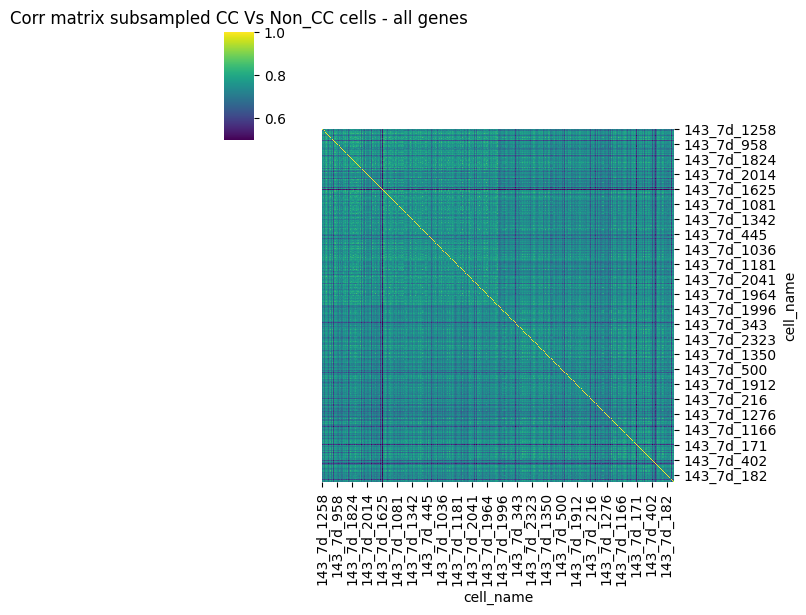

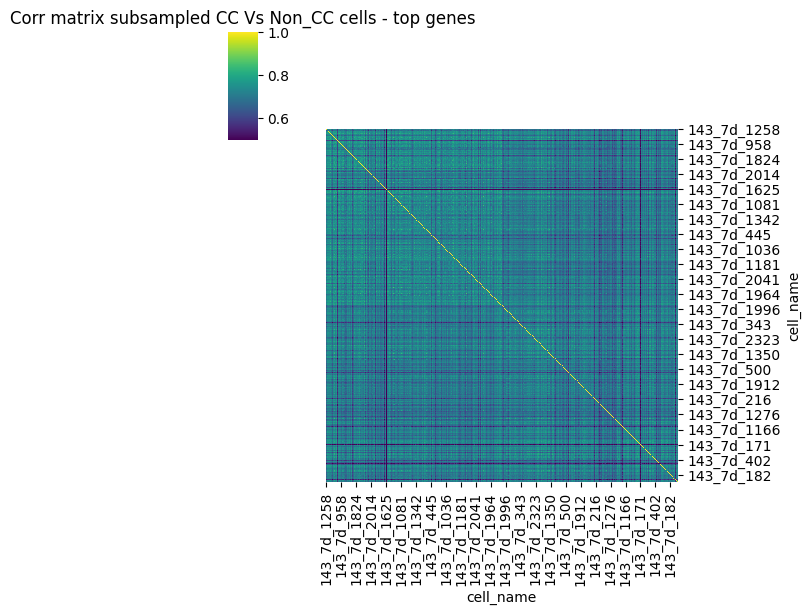

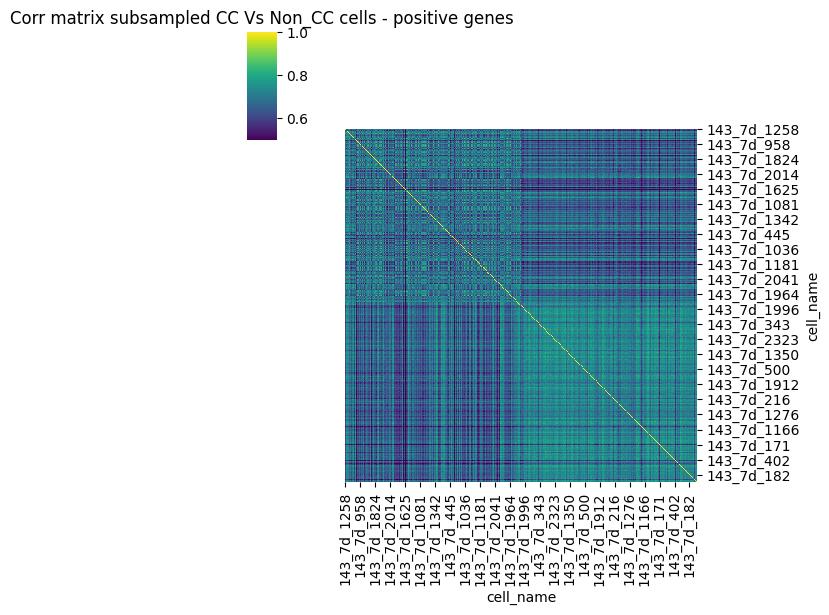

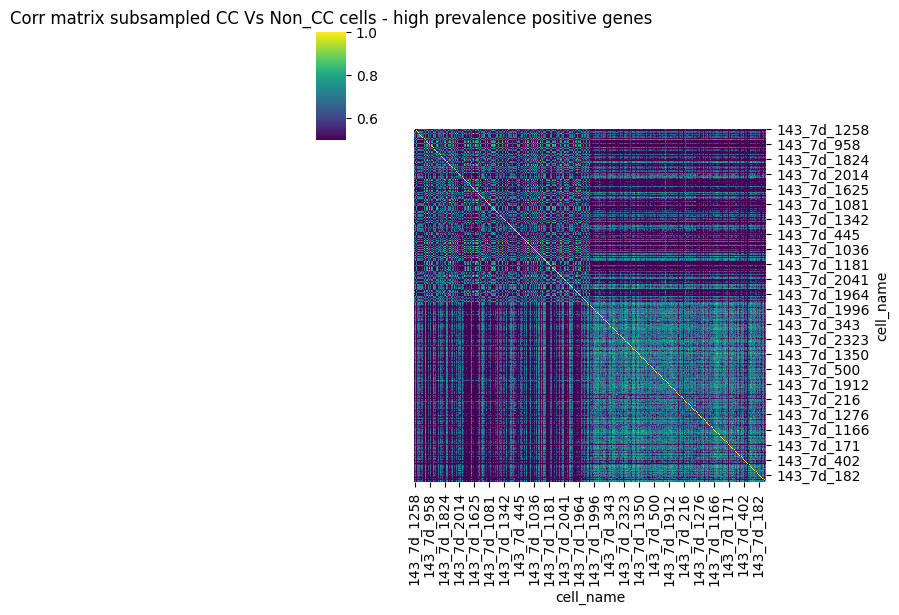

In [26]:
# all genes
df_all = pd.DataFrame(adata_cycling_subsampled[:, :].X.toarray(), # all genes
                  index=adata_cycling_subsampled.obs_names, 
                  columns=adata_cycling_subsampled.var_names)
corr_cells_df_all = df_all.T.corr() #to have cells has cols
display(corr_cells_df_all)

# all genes
df_top = pd.DataFrame(adata_cycling_subsampled[:, top_expressed_genes_in_adata].X.toarray(), # all genes
                  index=adata_cycling_subsampled.obs_names, 
                  columns=top_expressed_genes_in_adata)
corr_cells_df_top = df_top.T.corr() #to have cells has cols
display(corr_cells_df_top)

# only broad positive genes
df_1000 = pd.DataFrame(adata_cycling_subsampled[:, broad_positive_gene_list_in_adata].X.toarray(), # all genes
                  index=adata_cycling_subsampled.obs_names, 
                  columns=broad_positive_gene_list_in_adata)
corr_cells_df_1000 = df_1000.T.corr() #to have cells has cols
display(corr_cells_df_1000)


# only high prevalencebroad positive genes
df_100 = pd.DataFrame(adata_cycling_subsampled[:, high_prevalence_broad_positive_gene_list_in_adata].X.toarray(), # all genes
                  index=adata_cycling_subsampled.obs_names, 
                  columns=high_prevalence_broad_positive_gene_list_in_adata)
corr_cells_df_100 = df_100.T.corr() #to have cells has cols
display(corr_cells_df_100)

def plot_corr_matrix(corr_cells_df, title):
    sns.clustermap(
        corr_cells_df,  
        figsize=(6, 6),
        cmap="viridis",

        col_cluster=False, #wnat to cluster genes
        row_cluster=False,

        #method="average", # method to do clustering
        #metric="correlation", # metric to aggregate in hierarhcical clustering

        vmin = 0.5, vmax = 1, #for corr
        #standard_scale=0,#z_score=1 # for corr no need to scale
    )
    plt.title(title)
    plt.show()
plot_corr_matrix(corr_cells_df_all, title="Corr matrix subsampled CC Vs Non_CC cells - all genes")
plot_corr_matrix(corr_cells_df_top, title="Corr matrix subsampled CC Vs Non_CC cells - top genes")
plot_corr_matrix(corr_cells_df_1000, title="Corr matrix subsampled CC Vs Non_CC cells - positive genes")
plot_corr_matrix(corr_cells_df_100, title="Corr matrix subsampled CC Vs Non_CC cells - high prevalence positive genes")

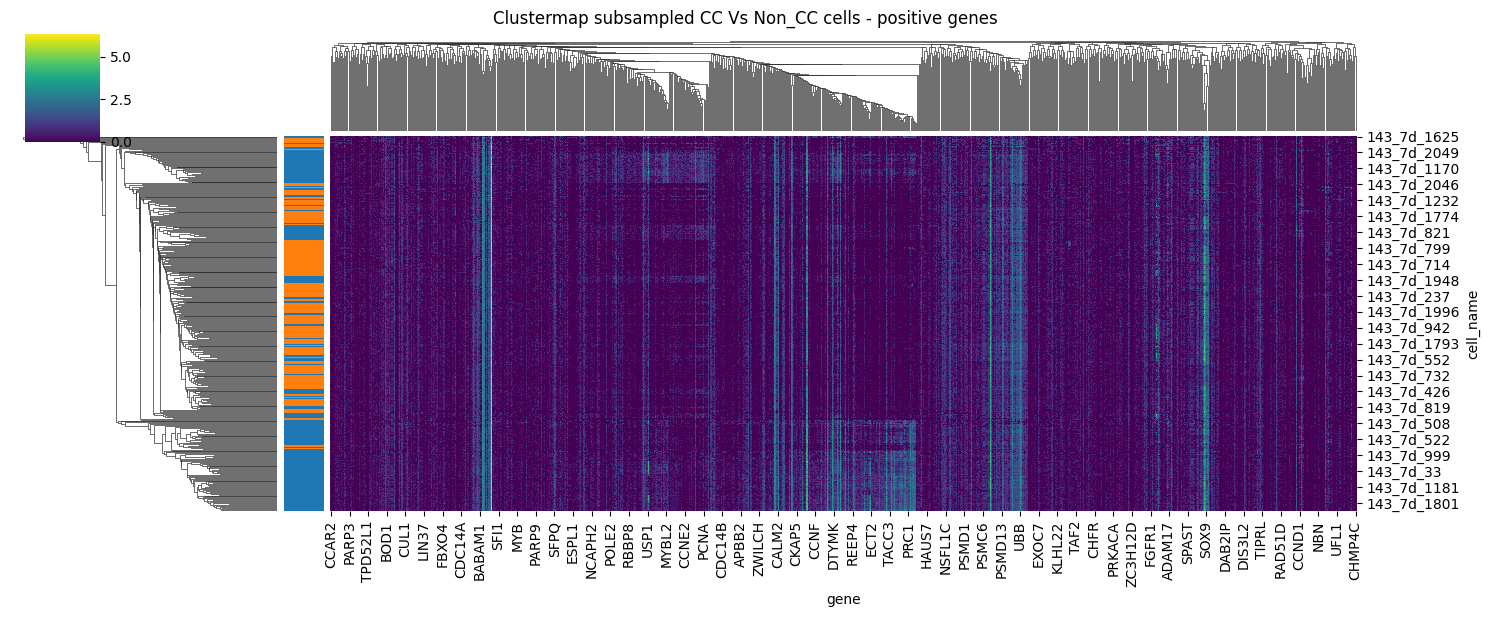

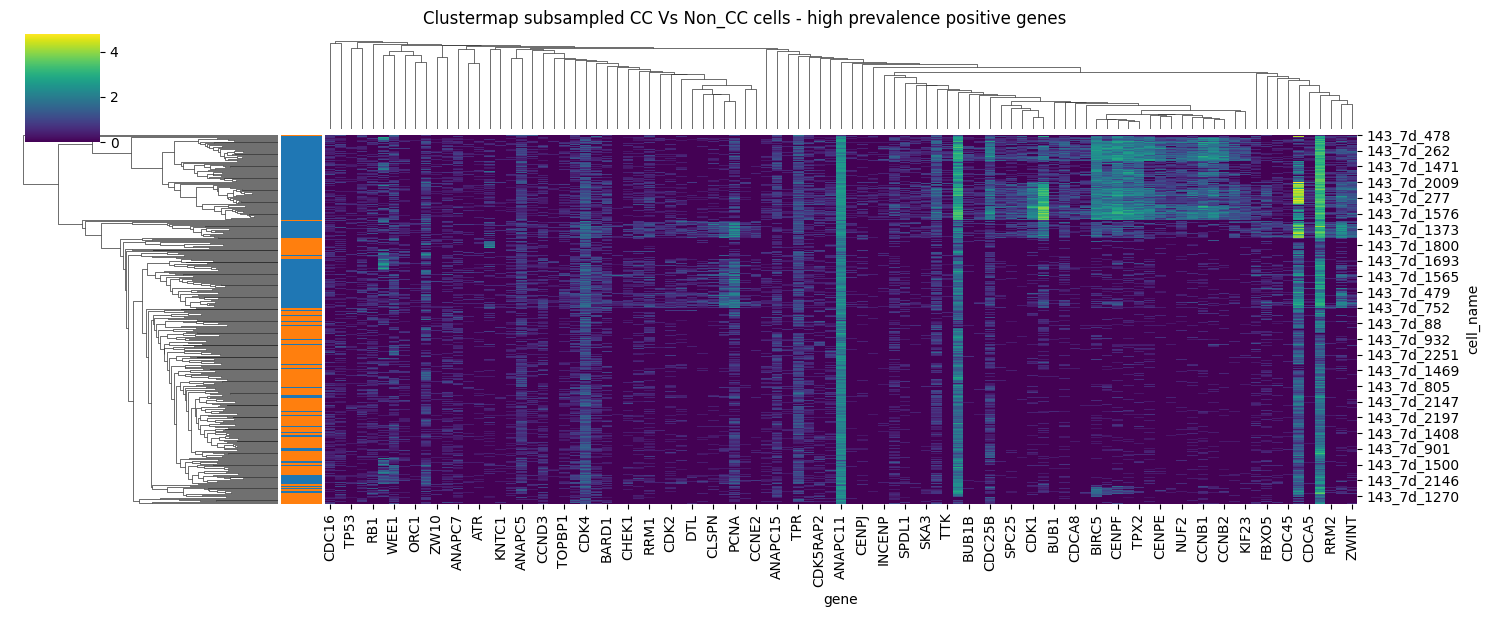

In [27]:

def plot_clustermap(adata, title):
    g = sc.pl.clustermap(
        adata,
        obs_keys="phase",
        use_raw=False,

        # to clustermap
        figsize=(15, 6),
        cmap="viridis",
        col_cluster=True, #wnat to cluster genes
        row_cluster=True,

        method="average", # method to do clustering
        metric="correlation", # metric to aggregate in hierarhcical clustering

        #vmin = -1, vmax = 1, #for corr
        standard_scale= None,# DATA ALREADY LOG NORMALISED
        z_score=None, # DATA ALREADY LOG NORMALISED
        show=False
    )
    g.fig.suptitle(title, y=1.02)  # y>1 places it above the plot
    plt.show()

adata_cycling_subsampled_1000 = adata_cycling_subsampled[:, broad_positive_gene_list_in_adata].copy()
plot_clustermap(adata_cycling_subsampled_1000, title="Clustermap subsampled CC Vs Non_CC cells - positive genes")

adata_cycling_subsampled_100 = adata_cycling_subsampled[:, high_prevalence_broad_positive_gene_list_in_adata].copy()
plot_clustermap(adata_cycling_subsampled_100, title="Clustermap subsampled CC Vs Non_CC cells - high prevalence positive genes")

In [28]:
VJKVJ

NameError: name 'VJKVJ' is not defined

# Select only cycling cells

Use precomputed labels:
- only cycling
- only malignant
    - why? dont want to have cell type influence the analysis

In [ ]:
# adata of 
    # only cycling cells
    # only malignanet
adata_cc = adata[
    #(adata.obs["cell_cycle_phase"] != "Not cycling") &
    (adata.obs["cell_cycle_phase"] != "Intermediate") &
    (adata.obs["cell_type"] == "Malignant") #like in apper https://www.weizmann.ac.il/sites/3CA/study-data/cell-cycle/20099
    ].copy()
print(adata_cc.obs.shape)

# ATTNETION: Remove genes with zero/low variance
gene_variances = np.var(adata_cc.X.toarray(), axis=0)
adata_cc = adata_cc[:, gene_variances > 1e-6].copy()

# Select postive genes in adata
print("Broad postive genes:", len(broad_positive_gene_list))
broad_positive_gene_list_in_adata = [g for g in broad_positive_gene_list if g in adata_cc.var_names]

broad_positive_gene_missing = set(broad_positive_gene_list).difference(broad_positive_gene_list_in_adata)
print("Broad postive genes in adata:", len(broad_positive_gene_list_in_adata))
print("Missing genes:", len(broad_positive_gene_missing), broad_positive_gene_missing)

(6697, 18)
Broad postive genes: 1148
Broad postive genes in adata: 1032
Missing genes: 116 {'MIR30C2', 'FIRRM', 'H2AZ1', 'PKHD1', 'NOP53', 'MRNIP', 'CEP43', 'H2BC7', 'MIR362', 'MIR214', 'MLF1IP', 'MIR133B', 'TENT4A', 'H2AZ2', 'MIR21', 'MIR26A1', 'MIR29A', 'H2BC21', 'MIR372', 'MAP3K20', 'WAPL', 'EPGN', 'CEP131', 'INS', 'NANOGP8', 'MIR424', 'OR2A4', 'MIR519D', 'MIR208A', 'MIR29B1', 'UHRF1', 'MIR193A', 'MIR10A', 'SGO2', 'BABAM2', 'H4C2', 'MIR222', 'ABRAXAS2', 'CENPS', 'H2BC4', 'H4C11', 'ABRAXAS1', 'CDC14C', 'NSD2', 'PRP4K', 'PCLAF', 'INTS13', 'TUBB8', 'SLF2', 'H2AX', 'DUX4', 'TUBB8B', 'MIR638', 'H2AC20', 'MIR515-1', 'H4C14', 'MIR503', 'MIR195', 'H4C3', 'CASP8AP2', 'MIR16-1', 'MOS', 'H2BC3', 'H4C8', 'MIR29C', 'PTENP1-AS', 'H4C6', 'KIF2B', 'CHMP4BP1', 'KNL1', 'H2BC11', 'MIR15B', 'MIR133A1', 'H2BC13', 'TUBA3C', 'MIR221', 'GPR15LG', 'PIMREG', 'SEM1', 'MIR495', 'MEIOC', 'CCNQ', 'MIR19B1', 'H2BC15', 'MIR451A', 'SLF1', 'TFDP3', 'CIP2A', 'CRNN', 'MIR15A', 'CEP295', 'PABIR1', 'RIPOR2', 'MIR137', '

### Oder cells by CC scores

In [ ]:
# Sort adata by "cc_score"strict_cc_genes
    # G2/M by g2m_score
    # G1/S by g1s_score 
    # Intermediate by mean_g1_g2_scores

# claculte mean for intermediate
adata_cc.obs["mean_g1_g2_scores"] = adata_cc.obs[["g1s_score", "g2m_score"]].mean(axis=1)

# Define your sorting rule
def sort_key(row):
    if row["cell_cycle_phase"] == "G2/M":
        return row["g2m_score"]
    elif row["cell_cycle_phase"] == "G1/S":
        return row["g1s_score"]
    # Intermediate
    elif row["cell_cycle_phase"] == "Intermediate":
        return row["mean_g1_g2_scores"]

# Apply the rule to create a sorting column
adata_cc.obs["sort_value"] = adata_cc.obs.apply(sort_key, axis=1)

adata_cc.obs

sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                               
102_1         102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2         102  Malignant        2366 -12.6327 -18.9353     1.1051   
102_4         102  Malignant        1217 -11.9102 -18.0864    -0.1774   
102_7         102  Malignant        1725  17.2946 -16.4965    -0.0337   
102_8         102  Malignant        2252  17.3138 -16.9457     0.0078   
...           ...        ...         ...      ...      ...        ...   
105_D1_149    105  Malignant        1085  29.0077   9.5856    -0.2635   
105_D2_90     105  Malignant        1128  10.2630   7.5104    -0.1585   
105_D2_93     105  Malignant        1116  28.8130   9.4526    -0.0661   
105_D2_139    105  Malignant        1029  28.8941   9.4308    -0.2548   
105_D2_148    105  Malignant        1035  29.0623   9.6065    -0.2660   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_1          0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_4         -0.0561      Not cycling        1.4340             Stress   
102_7         -0.0467      Not cycling        1.5445         NPC Glioma   
102_8         -0.0566      Not cycling        1.0364         NPC Glioma   
...               ...              ...           ...                ...   
105_D1_149    -0.0031      Not cycling        5.0555       Oligo normal   
105_D2_90     -0.0492      Not cycling        0.7036            NPC/OPC   
105_D2_93     -0.0623      Not cycling        4.6422       Oligo normal   
105_D2_139    -0.0581      Not cycling        4.9770       Oligo normal   
105_D2_148    -0.0584      Not cycling        5.2820       Oligo normal   

                mp_assignment  n_genes_by_counts  total_counts  \
cell_name                                                        
102_1        Oligo Progenitor               3113       11446.0   
102_2       Cell Cycle - G1/S               2374        6273.0   
102_4                     NaN               1220        2867.0   
102_7              NPC Glioma               1732        4911.0   
102_8              NPC Glioma               2263        6541.0   
...                       ...                ...           ...   
105_D1_149                NaN               1091        8103.0   
105_D2_90                 NaN               1138        8166.0   
105_D2_93                 NaN               1126        7357.0   
105_D2_139                NaN               1045        7953.0   
105_D2_148                NaN               1047        8796.0   

            total_counts_mt  pct_counts_mt  G2_M_score  G1_S_score  cc_score  \
cell_name                                                                      
102_1                 872.0       7.618382   -0.119369   -0.235912 -0.136094   
102_2                 165.0       2.630320    0.175133    0.325424  0.213183   
102_4                  64.0       2.232299   -0.012209   -0.124320 -0.015065   
102_7                 292.0       5.945836   -0.052760   -0.152413 -0.057671   
102_8                 193.0       2.950619   -0.056767   -0.157831 -0.064305   
...                     ...            ...         ...         ...       ...   
105_D1_149            255.0       3.146983   -0.061805   -0.179939 -0.052232   
105_D2_90             272.0       3.330884   -0.088143   -0.134415 -0.149114   
105_D2_93             182.0       2.473835   -0.138446   -0.173158 -0.060986   
105_D2_139            103.0       1.295109   -0.043099   -0.230465 -0.075781   
105_D2_148            221.0       2.512506   -0.112314   -0.168034 -0.081283   

            mean_g1_g2_scores  sort_value  
cell_name                                  
102_1                 0.04055         NaN  
102_2                 0.66795      1.1051  
102_4    

In [ ]:
# create df cell x gene with expression values inside
    # ATTENTION: filter only overlalping genes
df = pd.DataFrame(adata_cc[:, broad_positive_gene_list_in_adata].X.toarray(), 
                  index=adata_cc.obs_names, 
                  columns=broad_positive_gene_list_in_adata)

# Sort cells by phase with proper ordering
df_sorted = df.copy()
#df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"]
#df_sorted["sort_value"] = adata_cc.obs["sort_value"]

df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"].values.to_list()
df_sorted.loc[df_sorted["cell_cycle_phase"].isin(['G1/S' 'G2/M']), "cell_cycle_phase"] = "Cycling"
df_sorted["cell_cycle_phase"] = df_sorted["cell_cycle_phase"].replace({'G1/S': 'Cycling', 'G2/M': 'Cycling'})
df_sorted["cell_cycle_phase"] = pd.Categorical(df_sorted["cell_cycle_phase"], ordered=True)


df_sorted = df_sorted.groupby('cell_cycle_phase').apply(lambda x: x.sample(n=10, random_state=42))


phases_sorted = df_sorted["cell_cycle_phase"]


print(df_sorted["cell_cycle_phase"].unique())


df_sorted


['Cycling', 'Not cycling']
Categories (2, object): ['Cycling' < 'Not cycling']


/tmp/ipykernel_198267/2357357203.py:12: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"].values.to_list()
/tmp/ipykernel_198267/2357357203.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sorted = df_sorted.groupby('cell_cycle_phase').apply(lambda x: x.sample(n=10, random_state=42))
/tmp/ipykernel_198267/2357357203.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sorte

CDK1    FAM64A     H2AFZ  HIST1H4C  \
cell_cycle_phase cell_name                                             
Cycling          125_2_644    0.000000  0.000000  2.702561  2.702561   
                 102_904      2.086252  1.510134  3.591084  4.879094   
                 143_7d_1567  1.218619  1.939645  3.084063  0.000000   
                 124_1_54     2.458619  1.399680  3.235977  1.961193   
                 125_1_836    0.000000  0.000000  2.504696  1.672040   
                 125_1_120    1.498605  0.000000  3.543736  4.435693   
                 102_1053     1.410824  0.935963  3.051435  4.876510   
                 143_7d_2032  0.382556  0.874668  1.647550  1.449782   
                 125_1_162    1.027605  0.000000  3.114954  1.943223   
                 124_2_687    0.000000  0.513291  3.081644  1.303761   
Not cycling      105_C1_423   0.000000  0.000000  0.000000  0.000000   
                 102_1567     0.000000  0.000000  1.876790  1.326080   
                 105A_722     0.000000  0.000000  1.595505  0.000000   
                 115_1_347    0.000000  0.000000  0.000000  0.000000   
                 125_1_138    0.000000  0.000000  0.000000  1.809263   
                 105A_1502    0.000000  0.000000  1.207531  0.000000   
                 102_2056     0.000000  0.000000  1.227458  0.791304   
                 124_2_904    0.000000  0.000000  1.426490  0.000000   
                 102_156      1.175308  0.000000  2.813849  1.700791   
                 105_C1_222   0.000000  0.000000  1.392400  1.104042   

                                   HN1  KIAA0101     CCNB1      PLK1  \
cell_cycle_phase cell_name                                             
Cycling          125_2_644    1.916793  1.729759  0.000000  0.000000   
                 102_904      2.825716  1.510134  0.000000  0.000000   
                 143_7d_1567  2.687810  0.467267  1.850131  1.218619   
                 124_1_54     2.155795  0.000000  1.719342  1.399680   
                 125_1_836    1.004011  1.004011  0.000000  0.000000   
                 125_1_120    1.915804  1.915804  0.000000  0.000000   
                 102_1053     2.168863  2.331950  0.000000  0.000000   
                 143_7d_2032  2.188571  0.382556  1.052256  0.000000   
                 125_1_162    1.755264  2.413059  0.468829  0.000000   
                 124_2_687    1.102718  1.471073  0.850818  0.000000   
Not cycling      105_C1_423   0.000000  0.000000  0.000000  0.000000   
                 102_1567     2.490309  0.000000  0.000000  0.000000   
                 105A_722     0.000000  0.000000  0.000000  0.000000   
                 115_1_347    0.000000  0.000000  0.000000  0.000000   
                 125_1_138    0.000000  0.000000  0.000000  0.000000   
                 105A_1502    0.000000  0.000000  0.000000  0.000000   
                 102_2056     1.227458  0.000000  0.000000  0.000000   
                 124_2_904    3.141926  0.000000  0.000000  0.000000   
                 102_156      1.700791  0.000000  0.000000  0.000000   
                 105_C1_222   0.408183  0.000000  0.000000  0.000000   

                                 BIRC5       RB1  ...      TBCE  TPD52L1  \
cell_cycle_phase cell_name                        ...                      
Cycling          125_2_644    0.770027  0.000000  ...  0.000000      0.0   
                 102_904      0.000000  0.000000  ...  1.510134      0.0   
                 143_7d_1567  2.461408  0.000000  ...  0.000000      0.0   
                 124_1_54     1.719342  0.000000  ...  0.000000      0.0   
                 125_1_836    1.494793  0.000000  ...  0.000000      0.0   
                 125_1_120    1.915804  0.769404  ...  0.000000      0.0   
                 102_1053     0.935963  0.000000  ...  0.000000      0.0   
                 143_7d_2032  0.382556  0.000000  ...  0.000000      0.0   
                 125_1_162    1.383944  0.000000  ...  0.468829      0.0   
                 124_2_687  

FloatingPointError: NaN dissimilarity value.

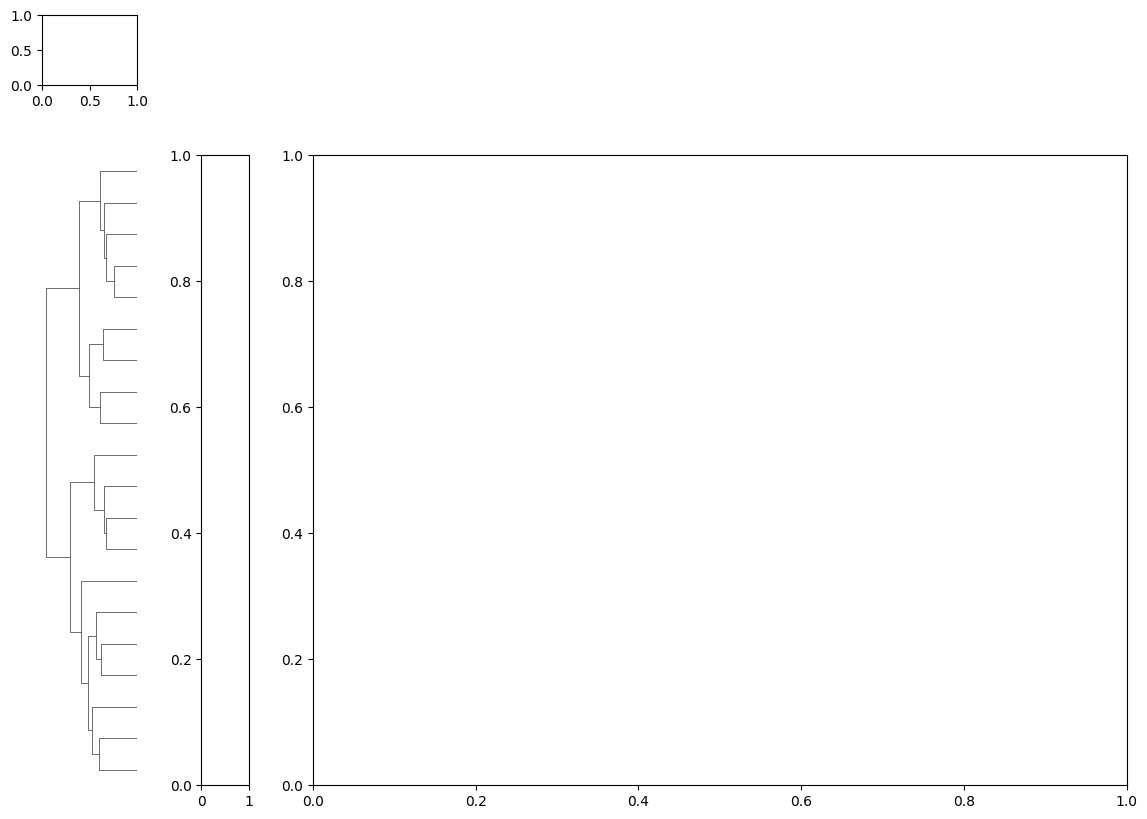

In [ ]:
phase_color_map = {
    'Cycling': '#1f77b4',
    'Not cycling': '#ff7f0e', 
}

phase_colors = phases_sorted.map(phase_color_map)


sns.clustermap(
    df_sorted.iloc[:, :-1],  # cells are row
    figsize=(14, 10),
    cmap="viridis",

    col_cluster=True, #wnat to cluster genes
    row_cluster=True,

    method="ward", # method to do clustering
    metric="correlation", # metric to aggregate in hierarhcical clustering

    row_colors=phase_colors,
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.05,  
    dendrogram_ratio=0.1,

    standard_scale=1, #for each row(0) or column, subtract the minimum and divide each by its maximum.

)

In [ ]:
# create df cell x gene with expression values inside
    # ATTENTION: filter only overlalping genes
df = pd.DataFrame(adata_cc[:, broad_positive_gene_list_in_adata].X.toarray(), 
                  index=adata_cc.obs_names, 
                  columns=broad_positive_gene_list_in_adata)

# Sort cells by phase with proper ordering
df_sorted = df.copy()
df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"]
df_sorted["sort_value"] = adata_cc.obs["sort_value"]

#Define phase order for sorting
phase_order = ['G1/S', 'Intermediate', 'G2/M'] 

# Convert to categorical with explicit order
df_sorted["cell_cycle_phase"] = pd.Categorical(df_sorted["cell_cycle_phase"], categories=phase_order, ordered=True)

# sort cell
    #before by cell phase
    # then by speific module
df_sorted = df_sorted.sort_values(["cell_cycle_phase"])#, "sort_value"])

# save for later
phases_sorted = df_sorted["cell_cycle_phase"]

# remove non numerical cols
df_sorted = df_sorted.drop(columns="cell_cycle_phase")
#df_sorted = df_sorted.drop(columns="sort_value")

display(df_sorted)

CDK1    FAM64A     H2AFZ  HIST1H4C       HN1  KIAA0101  CCNB1  \
cell_name                                                                       
102_2       1.432287  0.000000  2.829756  1.432287  1.998304  0.000000    0.0   
124_1_1100  1.328830  0.870586  3.144711  3.406335  2.371941  1.879960    0.0   
124_1_1095  0.519949  0.000000  1.753295  0.860306  0.000000  0.860306    0.0   
124_1_1029  0.000000  0.000000  2.835475  1.100215  1.793762  0.000000    0.0   
124_1_1021  0.000000  0.000000  3.155804  1.337364  2.243574  1.337364    0.0   
...              ...       ...       ...       ...       ...       ...    ...   
105_D1_149  0.000000  0.000000  0.000000  0.804184  0.000000  0.000000    0.0   
105_D2_90   0.000000  0.000000  1.541966  0.000000  1.541966  0.000000    0.0   
105_D2_93   0.000000  0.000000  3.289362  1.862062  0.858344  0.000000    0.0   
105_D2_139  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
105_D2_148  0.000000  0.000000  0.759347  2.418760  0.000000  0.000000    0.0   

            PLK1     BIRC5  RB1  ...      TBCE  TPD52L1  TUBD1  UBR7  USP19  \
cell_name                        ...                                          
102_2        0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
124_1_1100   0.0  0.870586  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
124_1_1095   0.0  0.000000  0.0  ...  0.519949      0.0    0.0   0.0    0.0   
124_1_1029   0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
124_1_1021   0.0  0.000000  0.0  ...  1.337364      0.0    0.0   0.0    0.0   
...          ...       ...  ...  ...       ...      ...    ...   ...    ...   
105_D1_149   0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
105_D2_90    0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
105_D2_93    0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
105_D2_139   0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   
105_D2_148   0.0  0.000000  0.0  ...  0.000000      0.0    0.0   0.0    0.0   

            USP50    YTHDC2    ZNF324    ZNHIT1  sort_value  
cell_name                                                    
102_2         0.0  0.953253  0.000000  0.000000      1.1051  
124_1_1100    0.0  0.000000  0.870586  0.870586      2.0566  
124_1_1095    0.0  0.519949  0.519949  1.483809      1.8084  
124_1_1029    0.0  0.694349  0.000000  1.793762      0.8485  
124_1_1021    0.0  1.337364  0.000000  1.337364      1.0983  
...           ...       ...       ...       ...         ...  
105_D1_149    0.0  0.000000  0.000000  2.679898         NaN  
105_D2_90     0.0  0.000000  0.000000  2.963666         NaN  
105_D2_93     0.0  0.000000  0.000000  1.862062         NaN  
105_D2_139    0.0  0.000000  0.000000  0.000000         NaN  
105_D2_148    0.0  0.000000  0.000000  1.899777         NaN  

[6697 rows x 1033 columns]

### Visual Inspection: gene pattern based on phase

Idea: Cluster genes and see if they cluster to speific cell phases.

Unique phases: ['G1/S', 'G2/M', NaN]
Categories (3, object): ['G1/S' < 'Intermediate' < 'G2/M']
Phase counts: cell_cycle_phase
G1/S            446
G2/M            285
Intermediate      0
Name: count, dtype: int64


FloatingPointError: NaN dissimilarity value.

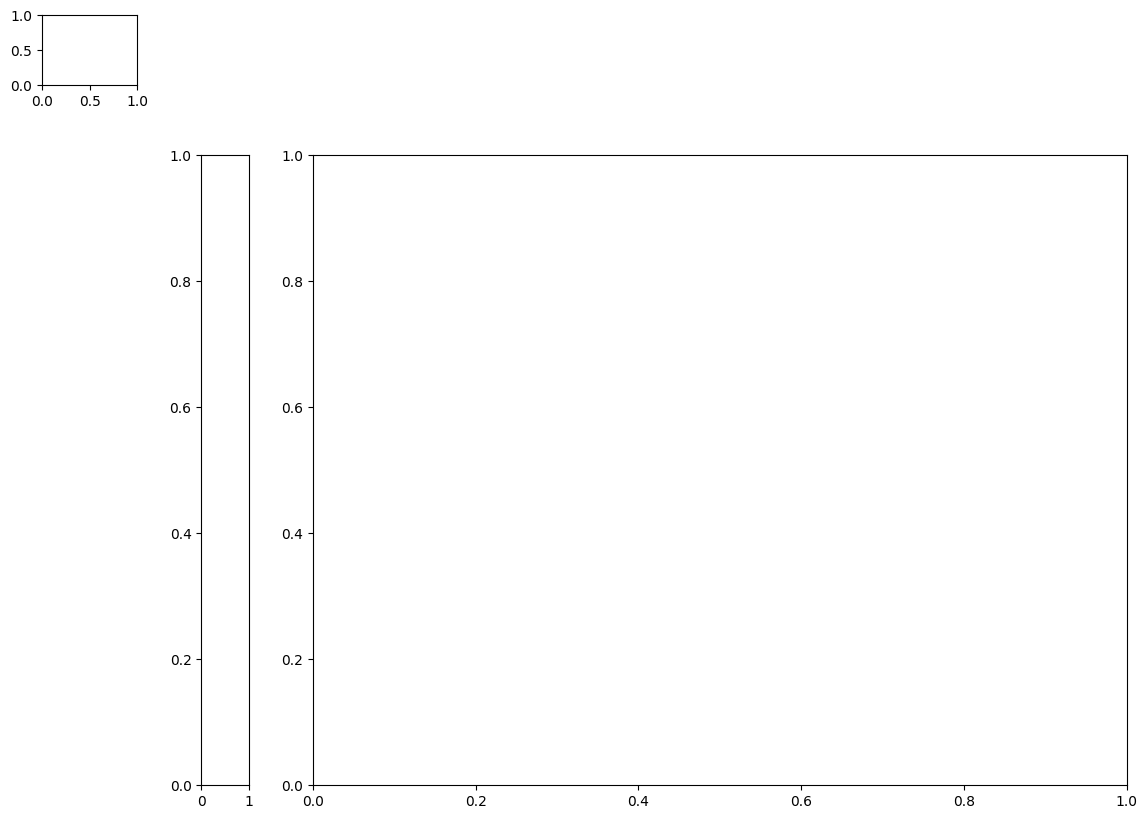

In [ ]:
# Create mapping: cell-phase --> color

# Check what phases you actually have
print("Unique phases:", phases_sorted.unique())
print("Phase counts:", phases_sorted.value_counts())

# Create color mapping - make sure these match your actual phase names
phase_color_map = {
    'G1/S': '#1f77b4',
    'Intermediate': '#ff7f0e', 
    'G2/M': '#2ca02c',
}

phase_colors = phases_sorted.map(phase_color_map)


#########


# Create the clustermap
g = sns.clustermap(
    df_sorted,  # cells are row
    figsize=(14, 10),
    cmap="viridis",

    col_cluster=True, #wnat to cluster genes
    row_cluster=True,

    method="average", # method to do clustering
    metric="correlation", # metric to aggregate in hierarhcical clustering

    row_colors=phase_colors,
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.05,  
    dendrogram_ratio=0.1,

    z_score=1,

    vmin = -1,
    vmax = 1,

)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=phase) 
                   for phase, color in phase_color_map.items()]
g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                    bbox_to_anchor=(1.02, 1), frameon=True)

In [ ]:
fnrioreoi

NameError: name 'fnrioreoi' is not defined

# 1. By Std

Rationale: a gene is cycling in CC if std across cell phases is high

Phase means shape: (3, 1014)
Phases: ['G1/S', 'G2/M', 'Intermediate']
Gene std shape: (1014,)
Number of variable genes: 760


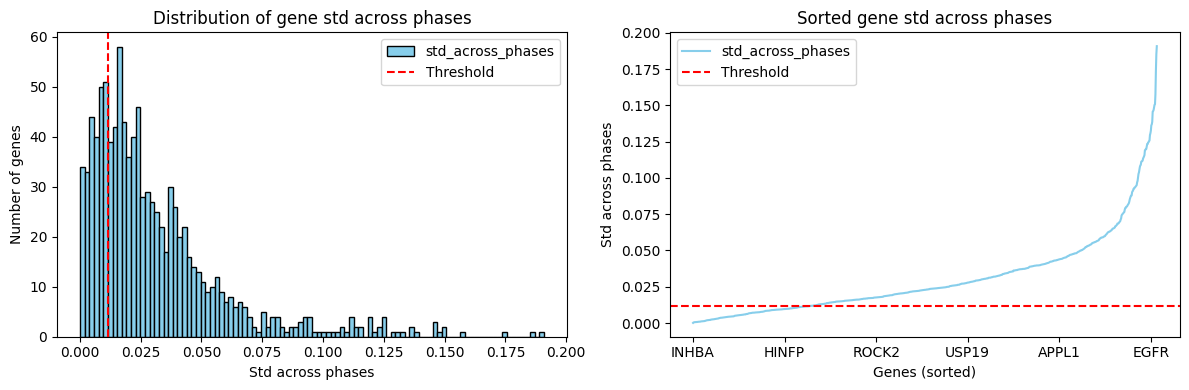

In [ ]:
# Add phase information
df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"].values

# Compute average expression per phase
phase_means = df_sorted.groupby("cell_cycle_phase", observed=False).mean() # Calculate the mean of ALL OTHER NUMERIC COLUMNS
print("Phase means shape:", phase_means.shape)  # Should be (3 phases, n_genes)
print("Phases:", phase_means.index.tolist())

# clauclte std acorss the precimputed means
phase_means.loc["std_across_phases"] = phase_means.std(axis=0)
print("Gene std shape:", phase_means.loc["std_across_phases"].shape)  # (n_genes,)

# Select genes with enough variance
threshold = phase_means.loc["std_across_phases"].quantile(0.25)  # e.g., 2nd percentile

# Genes with high or low variance
variable_genes = phase_means.columns[phase_means.loc["std_across_phases"] > threshold]
constant_genes = phase_means.columns[phase_means.loc["std_across_phases"] <= threshold]

print("Number of variable genes:", len(variable_genes))

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
phase_means.loc["std_across_phases"].plot(kind="hist", bins=100, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Distribution of gene std across phases")
plt.xlabel("Std across phases")
plt.ylabel("Number of genes")
plt.legend()

# Sorted values
plt.subplot(1, 2, 2)
phase_means.loc["std_across_phases"].sort_values().plot(color='skyblue')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Sorted gene std across phases")
plt.xlabel("Genes (sorted)")
plt.ylabel("Std across phases")
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.05, 'Clustermap of variable genes')

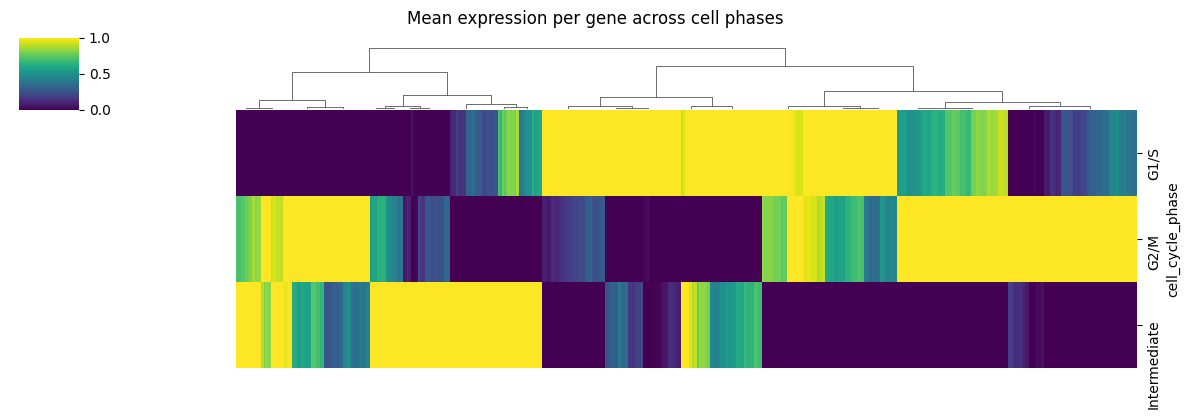

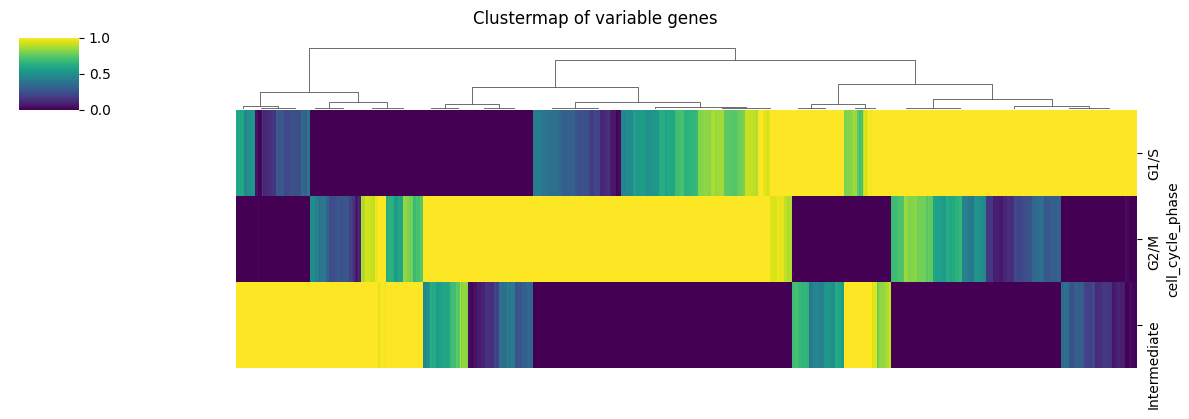

In [ ]:
# Full phase_means clustermap
sns.clustermap(
    phase_means.iloc[:-1, :],  # exclude std row if needed
    figsize=(12, 4),
    cmap="viridis",
    col_cluster=True,  # cluster genes
    row_cluster=False, # do not cluster phases
    method="average",
    metric="correlation",
    xticklabels=False,
    yticklabels=True,
    standard_scale=1,
)
plt.suptitle("Mean expression per gene across cell phases", y=1.05)

# Variable genes only
sns.clustermap(
    phase_means.iloc[:-1, :][variable_genes],  # exclude std row if needed
    figsize=(12, 4),
    cmap="viridis",
    col_cluster=True,  # cluster genes
    row_cluster=False, # do not cluster phases
    method="average",
    metric="correlation",
    xticklabels=False,
    yticklabels=True,
    standard_scale=1,
)
plt.suptitle("Clustermap of variable genes", y=1.05)


In [ ]:
# add results to df
positive_genes_df["p_by_std"] = [g in variable_genes for g in positive_genes_df.gene.to_list()]

# By Kruskal test


In [ ]:
# import numpy as np
# from scipy.stats import kruskal
# from statsmodels.stats.multitest import multipletests

# # Test each gene for differential expression across phases
# results = []

# for gene in broad_positive_gene_list_in_adata:
#     # Get expression values per phase
#     expr_by_phase = {} #A dictionary with N(one per phase) lists (each elemnt is a cell) of expression values 
#     for phase in adata_cc.obs['cell_cycle_phase'].unique():
#         cells = adata_cc.obs['cell_cycle_phase'] == phase #extract all cells in that phase
#         expr_by_phase[phase] = adata_cc[cells, gene].X.toarray().flatten() #Get expression values for the gene across those cells
    
#     # Check if gene has any variance at all
#     all_values = np.concatenate(list(expr_by_phase.values()))
#     if np.std(all_values) < 1e-10:  # Skip genes with no variance
#         continue
    
#     # Check if there's variance within at least 2 groups
#     variances = [np.std(v) for v in expr_by_phase.values()]
#     if sum(v > 1e-10 for v in variances) < 2:  # Need variance in at least 2 phases
#         continue
    
#     try:
#         # Kruskal-Wallis test (non-parametric ANOVA) 
#         # Treats each cell independently (ignores biological replicates) --> WRING !!!
#         stat, pval = kruskal(*expr_by_phase.values())
        
#         # Calculate effect size (variance across phase means)
#         #p-value tells you IF there's a difference
#         #Effect size tells you HOW BIG the difference is
#         phase_means = [np.mean(v) for v in expr_by_phase.values()]
#         effect_size = np.std(phase_means)
        
#         results.append({
#             'gene': gene,
#             'pvalue': pval,
#             'effect_size': effect_size,
#             'mean_expr': np.mean(all_values)
#         })
#     except ValueError:
#         # Skip genes that still cause issues
#         continue

# results_df = pd.DataFrame(results)

# # multi teset conrrection
# results_df['pvalue_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

# # Keep genes with significant variation AND large effect
# cc_genes = results_df[
#     (results_df['pvalue_adj'] < 0.05) & 
#     (results_df['effect_size'] > results_df['effect_size'].quantile(0.2))  
# ]['gene'].tolist()

# print(f"Found {len(cc_genes)} cell cycle genes")
# display(results_df.sort_values('effect_size', ascending=False))

# sorted(cc_genes)

# positive_genes_df["p_by_kruskal"] = [g in cc_genes for g in positive_genes_df.gene.to_list()]


# By Wilcoxon Test

Not optimal test for scrna (nned pseudobulk and desseq2 or Limma or EdgeR)

In [ ]:
# Test all genes at once
sc.tl.rank_genes_groups( # ATTENTION; needs log norm data
    adata_cc, 
    groupby='cell_cycle_phase',
    method='wilcoxon',  # one-vs-rest comparisons
                        # so a gene will be tested n choose k times (in or case 3)
    key_added='phase_de',
    use_raw=False
)

print(adata_cc.uns["phase_de"])

# Extract results --> covert to df
# 1. Significant in at least one phase
# 2. Have large fold change
results = sc.get.rank_genes_groups_df(adata_cc, group=None, key='phase_de')

# Filter
wilcoxon_positive_genes_df = results[
    results['names'].isin(broad_positive_gene_list_in_adata) &
    (results['pvals_adj'] <= 0.05) &
    (results['logfoldchanges'].abs() >= 0.2)
]

display(wilcoxon_positive_genes_df)

{'params': {'groupby': 'cell_cycle_phase', 'reference': 'rest', 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('GINS2', 'PTTG1', 'HIST1H4C'), ('MCM5', 'CDC20', 'ESCO2'),
           ('MCM3', 'CCNB1', 'RRM2'), ..., ('CENPF', 'MCM7', 'S100B'),
           ('BIRC5', 'GINS2', 'C1orf61'), ('PTTG1', 'PCNA', 'EEF1A1')],
          dtype=[('G1/S', 'O'), ('G2/M', 'O'), ('Intermediate', 'O')]), 'scores': rec.array([( 15.677265,  21.515015, 12.017877 ),
           ( 14.989848,  20.629004, 10.696493 ),
           ( 14.165375,  20.258718, 10.692378 ), ...,
           (-21.591904, -15.665862, -5.8960347),
           (-21.817354, -16.489542, -6.131504 ),
           (-22.84768 , -17.405153, -6.5618258)],
          dtype=[('G1/S', '<f4'), ('G2/M', '<f4'), ('Intermediate', '<f4')]), 'pvals': rec.array([(2.16371113e-055, 1.12641805e-102, 2.86232820e-33),
           (8.55482441e-051, 1.50721551e-094, 1.05702927e-26),
           (1.50064233e-0

group   names     scores  logfoldchanges         pvals  \
0              G1/S   GINS2  15.677265        2.236144  2.163711e-55   
1              G1/S    MCM5  14.989848        2.684346  8.554824e-51   
2              G1/S    MCM3  14.165375        2.058793  1.500642e-45   
3              G1/S    PCNA  12.794274        1.390431  1.764941e-37   
4              G1/S    MCM7  12.097391        1.597906  1.090211e-33   
...             ...     ...        ...             ...           ...   
38892  Intermediate  DYNLL2   3.248795        0.574605  1.158949e-03   
38901  Intermediate  ARID1A   3.218020        0.531101  1.290790e-03   
38904  Intermediate   CENPP   3.209073        0.800137  1.331635e-03   
38905  Intermediate   TFDP1   3.207642        0.514562  1.338280e-03   
57672  Intermediate  RPS27A  -3.890073       -0.225869  1.002140e-04   

          pvals_adj  
0      1.156143e-52  
1      4.013673e-48  
2      5.154706e-43  
3      4.297521e-35  
4      2.356325e-31  
...             ...  
38892  4.440943e-02  
38901  4.821287e-02  
38904  4.945046e-02  
38905  4.960147e-02  
57672  6.299727e-03  

[860 rows x 6 columns]

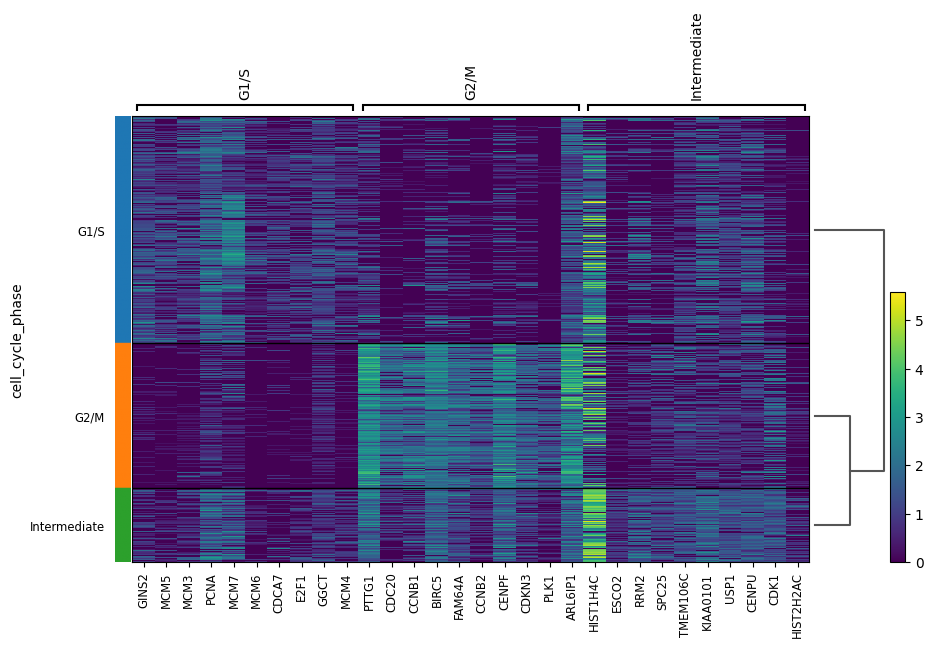

In [ ]:
sc.pl.rank_genes_groups_heatmap(
    adata_cc,
    #groups=,
    key="phase_de",
    n_genes=10, # negative fro downregulated genes
    show_gene_labels=True
)
# Cols are the top genes for each group (e.g., the top 10 markers for Cluster 1, followed by the top 10 for Cluster 2, etc.)
# Row aew cells of that group
#Color Intensity typically represents the ean expression (or Z-score) of the gene

In [ ]:
# add
positive_genes_df["p_by_wilcoxon"] = [g in wilcoxon_positive_genes_df.names.to_list() for g in positive_genes_df.gene.to_list()]


Unique phases: ['G1/S', 'Intermediate', 'G2/M']
Categories (3, object): ['G1/S' < 'Intermediate' < 'G2/M']
Phase counts: cell_cycle_phase
G1/S            446
G2/M            285
Intermediate    146
Name: count, dtype: int64
G1/S
G2/M
Intermediate


/tmp/ipykernel_12072/1791245734.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, g in wilcoxon_positive_genes_df.sort_values(by="scores").groupby("group"):


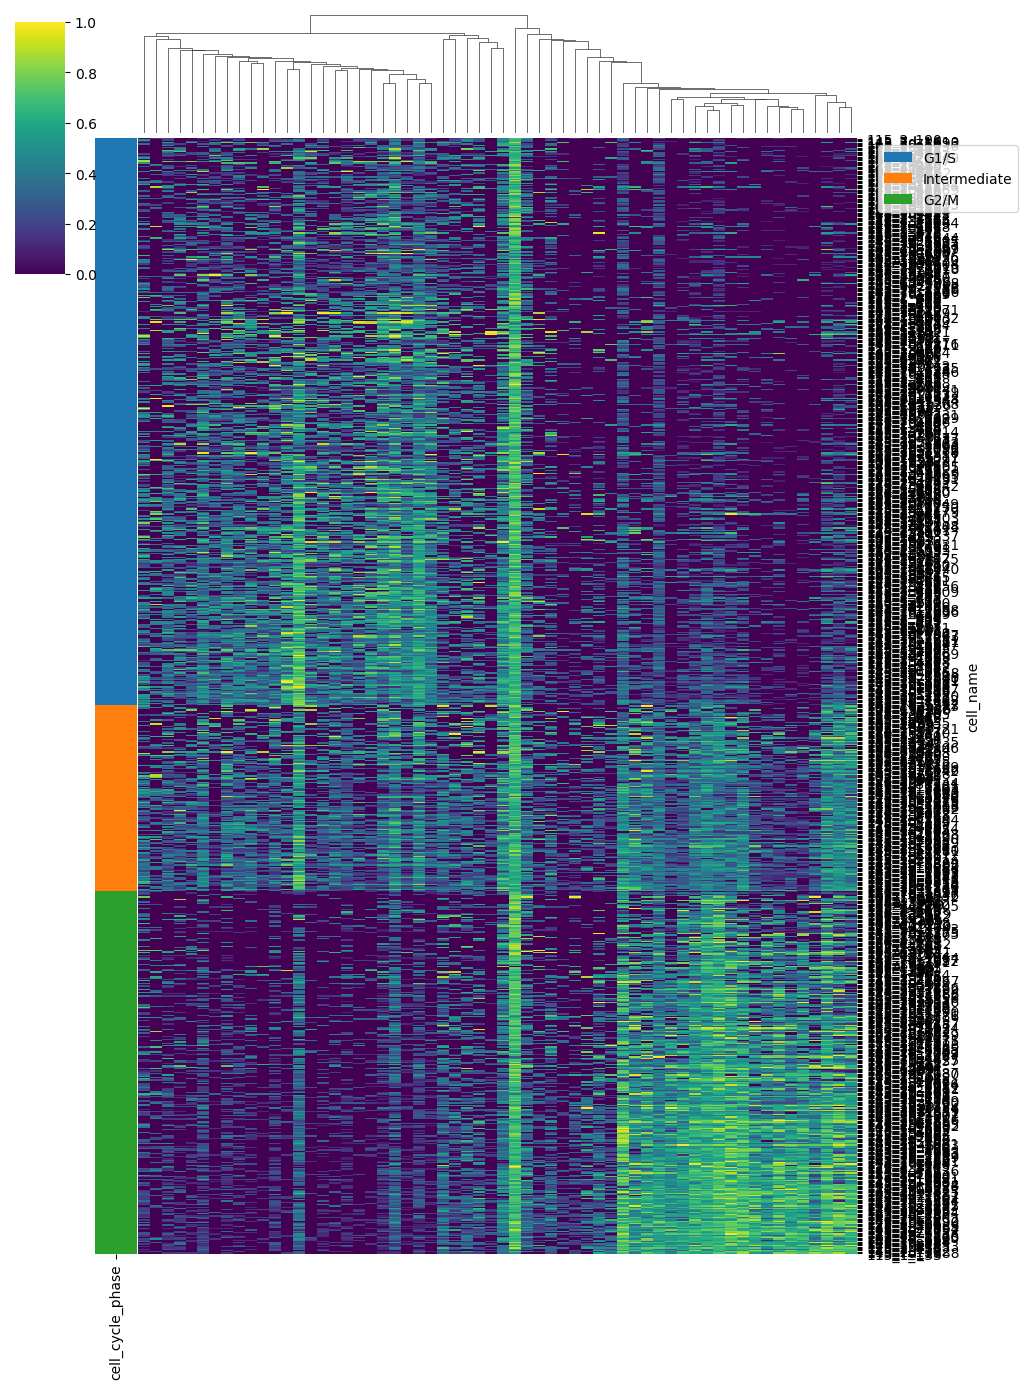

In [ ]:
# Create mapping: cell-phase --> color

# Check what phases you actually have
print("Unique phases:", phases_sorted.unique())
print("Phase counts:", phases_sorted.value_counts())

# Create color mapping - make sure these match your actual phase names
phase_color_map = {
    'G1/S': '#1f77b4',
    'Intermediate': '#ff7f0e', 
    'G2/M': '#2ca02c',
}

phase_colors = phases_sorted.map(phase_color_map)


#########

# get the most iffrtuallye xpressed gens ofr wach group:
N=20
genes_list = []
for i, g in wilcoxon_positive_genes_df.sort_values(by="scores").groupby("group"):
    print(i)
    #display(g)
    genes_list = genes_list + g.names[:N].to_list()

genes_list


########


# Create the clustermap
g = sns.clustermap(
    df_sorted.loc[:, df_sorted.columns.isin(genes_list)],  # cells are row
    figsize=(10, 14),
    cmap="viridis",

    col_cluster=True, #wnat to cluster genes
    row_cluster=False,

    method="average", # method to do clustering
    metric="correlation", # metric to aggregate in hierarhcical clustering

    row_colors=phase_colors,
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.05,  
    dendrogram_ratio=0.1,

    standard_scale=1, #for each row(0) or column, subtract the minimum and divide each by its maximum.

)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=phase) 
                   for phase, color in phase_color_map.items()]
g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                    bbox_to_anchor=(1.02, 1), frameon=True)

# Final Decision

<Axes: xlabel='n_positive'>

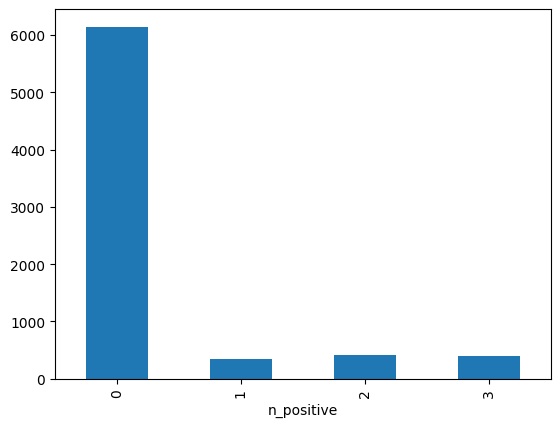

In [ ]:
# add if it was èsotve before
positive_genes_df["p_by_broad"] = [g in positive_genes_df[positive_genes_df.label == "positive"].gene.to_list() for g in positive_genes_df.gene.to_list()]

# count
positive_genes_df["n_positive"] = positive_genes_df.apply(
    lambda x: x[["p_by_broad", "p_by_std", "p_by_wilcoxon"]].sum(),
    axis=1
)

# sort
positive_genes_df = positive_genes_df.sort_values(by="n_positive", ascending=False)

positive_genes_df.n_positive.value_counts().sort_index().plot(kind="bar")

In [ ]:
# asing label
THR=3
positive_genes_df["definitive_positive"] = [True if g in positive_genes_df[positive_genes_df["n_positive"] >= THR].gene.to_list() else False for g in positive_genes_df.gene]

# see inly rwl ptiise
definitive_df = positive_genes_df[positive_genes_df["definitive_positive"] == True].sort_values(by="gene")
display(definitive_df)

print(definitive_df.gene.to_list())


gene  geneset_count  is_guaranteed     label  geneset_percent  \
74    ANAPC11             39          False  positive        13.402062   
77    ANAPC15             38          False  positive        13.058419   
488   ANAPC16             16          False  positive         5.498282   
75     ANAPC5             39          False  positive        13.402062   
965    ANKLE2              9          False  positive         3.092784   
...       ...            ...            ...       ...              ...   
960     YWHAH             10          False  positive         3.436426   
487   ZFP36L1             17          False  positive         5.841924   
1147   ZNHIT1              8          False  positive         2.749141   
123    ZWILCH             32          False  positive        10.996564   
34      ZWINT             48           True  positive        16.494845   

      p_by_std  p_by_wilcoxon  p_by_broad  n_positive  definitive_positive  
74        True           True        True           3                 True  
77        True           True        True           3                 True  
488       True           True        True           3                 True  
75        True           True        True           3                 True  
965       True           True        True           3                 True  
...        ...            ...         ...         ...                  ...  
960       True           True        True           3                 True  
487       True           True        True           3                 True  
1147      True           True        True           3                 True  
123       True           True        True           3                 True  
34        True           True        True           3                 True  

[392 rows x 10 columns]

['ANAPC11', 'ANAPC15', 'ANAPC16', 'ANAPC5', 'ANKLE2', 'ANKRD17', 'ANP32E', 'ARF6', 'ARHGEF39', 'ARL6IP1', 'ASPM', 'ATAD2', 'ATAD5', 'AURKA', 'AURKB', 'BABAM1', 'BAZ1B', 'BCL7A', 'BCL7B', 'BCL7C', 'BID', 'BIRC5', 'BORA', 'BRCA1', 'BRCA2', 'BRD7', 'BRD8', 'BTG3', 'BUB1', 'BUB1B', 'BUB3', 'CALM1', 'CALM2', 'CALM3', 'CCNA2', 'CCNB1', 'CCNB2', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2', 'CCNF', 'CCNG1', 'CCNG2', 'CCNH', 'CCSAP', 'CDC20', 'CDC25A', 'CDC25B', 'CDC25C', 'CDC27', 'CDC45', 'CDC5L', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA5', 'CDCA7', 'CDCA8', 'CDK1', 'CDK16', 'CDK2', 'CDK2AP2', 'CDK4', 'CDK5RAP2', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2C', 'CDKN2D', 'CDKN3', 'CDT1', 'CENPA', 'CENPE', 'CENPF', 'CENPH', 'CENPJ', 'CENPK', 'CENPL', 'CENPM', 'CENPN', 'CENPO', 'CENPQ', 'CENPU', 'CENPV', 'CENPW', 'CEP135', 'CEP152', 'CEP55', 'CEP70', 'CEP78', 'CFLAR', 'CHAF1A', 'CHAF1B', 'CHEK1', 'CHEK2', 'CHMP4B', 'CIT', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN', 'CNTRL', 'CRY1', 'CSNK1E', 'CTCF', 'CTD

# Save

In [ ]:
positive_genes_df.to_csv(config["data_paths"]["final_positive_genes"], index=False)

# Caveats

1) missing genes in scrna daatset ase not studied
2) removed geens with  expresson
3) some genes are expressed in mutple pahses (ex CDK1)
4) cell type expression differces are not accounted
5) using std, we have to average bvefpre. bit mean is not a good metric for spiky expression
6) stat tets not ptimal for scrna data

 ---
# Optional
 ---

# Compare to non cyclins cells

These postive gens shoudl be much more expressed

In [ ]:
# adata of only cycling cells
# 1. Get the indices (cell names) of the top 200 scores
top_200_indices = adata.obs["cc_score"].nlargest(200).index
# 2. Get the indices (cell names) of the bottom 200 scores
bottom_200_indices = adata.obs["cc_score"].nsmallest(200).index
selected_indices = top_200_indices.tolist() + bottom_200_indices.tolist()

adata_binary = adata[selected_indices, definitive_df.gene.to_list()].copy()

# Create a new column in adata_binary.obs to label the groups
group_labels = []
for cell in adata_binary.obs_names:
    if cell in top_200_indices:
        group_labels.append("Top_200_Score")
    elif cell in bottom_200_indices:
        group_labels.append("Bottom_200_Score")

adata_binary.obs["cc_group"] = pd.Categorical(group_labels)

# Sort the observation metadata by cc_score
adata_binary.obs.sort_values(by='cc_score', ascending=True, inplace=True)
# Reindex the AnnData object based on the sorted order of .obs
adata_binary = adata_binary[adata_binary.obs_names, :].copy()

adata_binary

AnnData object with n_obs × n_vars = 400 × 392
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'G2_M_score', 'G1_S_score', 'cc_score', 'cc_group'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'cell_type_colors', 'sample_colors', 'cell_cycle_phase_colors'
    obsm: 'umap'

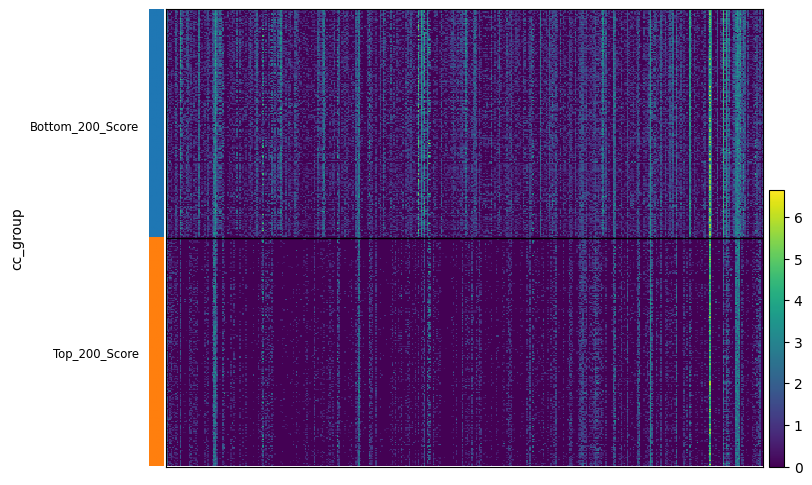

In [ ]:
sc.pl.heatmap(
    adata_binary,
    var_names = adata_binary.var_names,
    groupby="cc_group",
    #log=True,
    #standard_scale="obs"
    #swap_axes=True,
    #show_gene_labels=True
    dendrogram=False
)

# Are there Enriched genesets?

After getting definitive positive genes, perform hypergeometric test.

Universe is ALL genesets (not jsut the one found previusly) with AT LEAST 10 genes.

In [ ]:
# plit psoive genes
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
print("Number positive genes", len(positive_genes))

# Read MSigDB genesets
df_genesets = dataf.load_json_folder_to_df(config["data_paths"]["MSigDB_all_data"])
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')
# rename
df_genesets["gene_list"] = df_genesets["geneSymbols"]
# Recalculate n_genes
df_genesets["n_genes"] = df_genesets["gene_list"].apply(len)
#subset
df_genesets = df_genesets[["set_name", "gene_list", "n_genes"]]

#  extartc only psotive geens per geneset
df_genesets["genes_positive"] = df_genesets.apply(
    lambda row: (
        [g for g in row["gene_list"] if g in positive_genes]
    ),
    axis=1
)
df_genesets["n_genes_positive"] = df_genesets["genes_positive"].apply(len)
df_genesets.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(df_genesets.head(5))

############

# read psortive genesets found before
df_genesets_positive = pd.read_csv(config["data_paths"]["positive_genesets"])
df_genesets_positive["gene_list"] = df_genesets_positive["geneSymbols"].apply(ast.literal_eval)
df_genesets_positive = df_genesets_positive[["set_name", "gene_list", "n_genes"]]
df_genesets_positive["genes_positive"] = df_genesets_positive.apply(
lambda row: (
        [g for g in row["gene_list"] if g in positive_genes]
    ),
    axis=1
)
df_genesets_positive["n_genes_positive"] = df_genesets_positive["genes_positive"].apply(len)
df_genesets_positive.sort_values(by="n_genes_positive", ascending=False, inplace=True)
# ratio of psotve genes
df_genesets_positive["n_genes_ratio"] = df_genesets_positive["n_genes_positive"] / df_genesets_positive["n_genes"]

display(df_genesets_positive.head(5))


Number positive genes 392


set_name  \
19134                            GOBP_CELL_CYCLE   
20256                    GOBP_CELL_CYCLE_PROCESS   
33730                      FISCHER_DREAM_TARGETS   
57722  HE_LIM_SUN_FETAL_LUNG_C5_LARGE_PRE_B_CELL   
18135                    GOBP_MITOTIC_CELL_CYCLE   

                                               gene_list  n_genes  \
19134  [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
20256  [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
33730  [AAAS, AARS1, ABCB10, ABCE1, ABHD10, ABHD2, AC...      969   
57722  [AAAS, AAGAB, AAMDC, AARS1, ABCD3, ABHD12, ABH...     1363   
18135  [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   

                                          genes_positive  n_genes_positive  
19134  [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305  
20256  [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287  
33730  [ANKRD17, ANP32E, ARHGEF39, ARL6IP1, ASPM, ATA...               259  
57722  [ANAPC15, ANP32E, ARHGEF39, ARL6IP1, ASPM, ATA...               244  
18135  [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241

set_name  \
49                            GOBP_CELL_CYCLE   
66                    GOBP_CELL_CYCLE_PROCESS   
44                    GOBP_MITOTIC_CELL_CYCLE   
290   HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_T_CELL   
287  HE_LIM_SUN_FETAL_LUNG_C2_CYCLING_DC_CELL   

                                             gene_list  n_genes  \
49   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
66   [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
44   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   
290  [A1BG, AAAS, AARS1, ABHD12, ABI2, ACAD9, ACAT2...      939   
287  [AAAS, AARS1, AARS2, AASDH, ABCB7, ABCB8, ACAA...     1423   

                                        genes_positive  n_genes_positive  \
49   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305   
66   [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287   
44   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241   
290  [ANAPC15, ARHGEF39, ARL6IP1, ASPM, ATAD2, ATAD...               231   
287  [ANAPC15, ARHGEF39, ASPM, ATAD2, ATAD5, AURKA,...               227   

     n_genes_ratio  
49        0.178886  
66        0.212908  
44        0.258861  
290       0.246006  
287       0.159522

/tmp/ipykernel_12072/1603268317.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


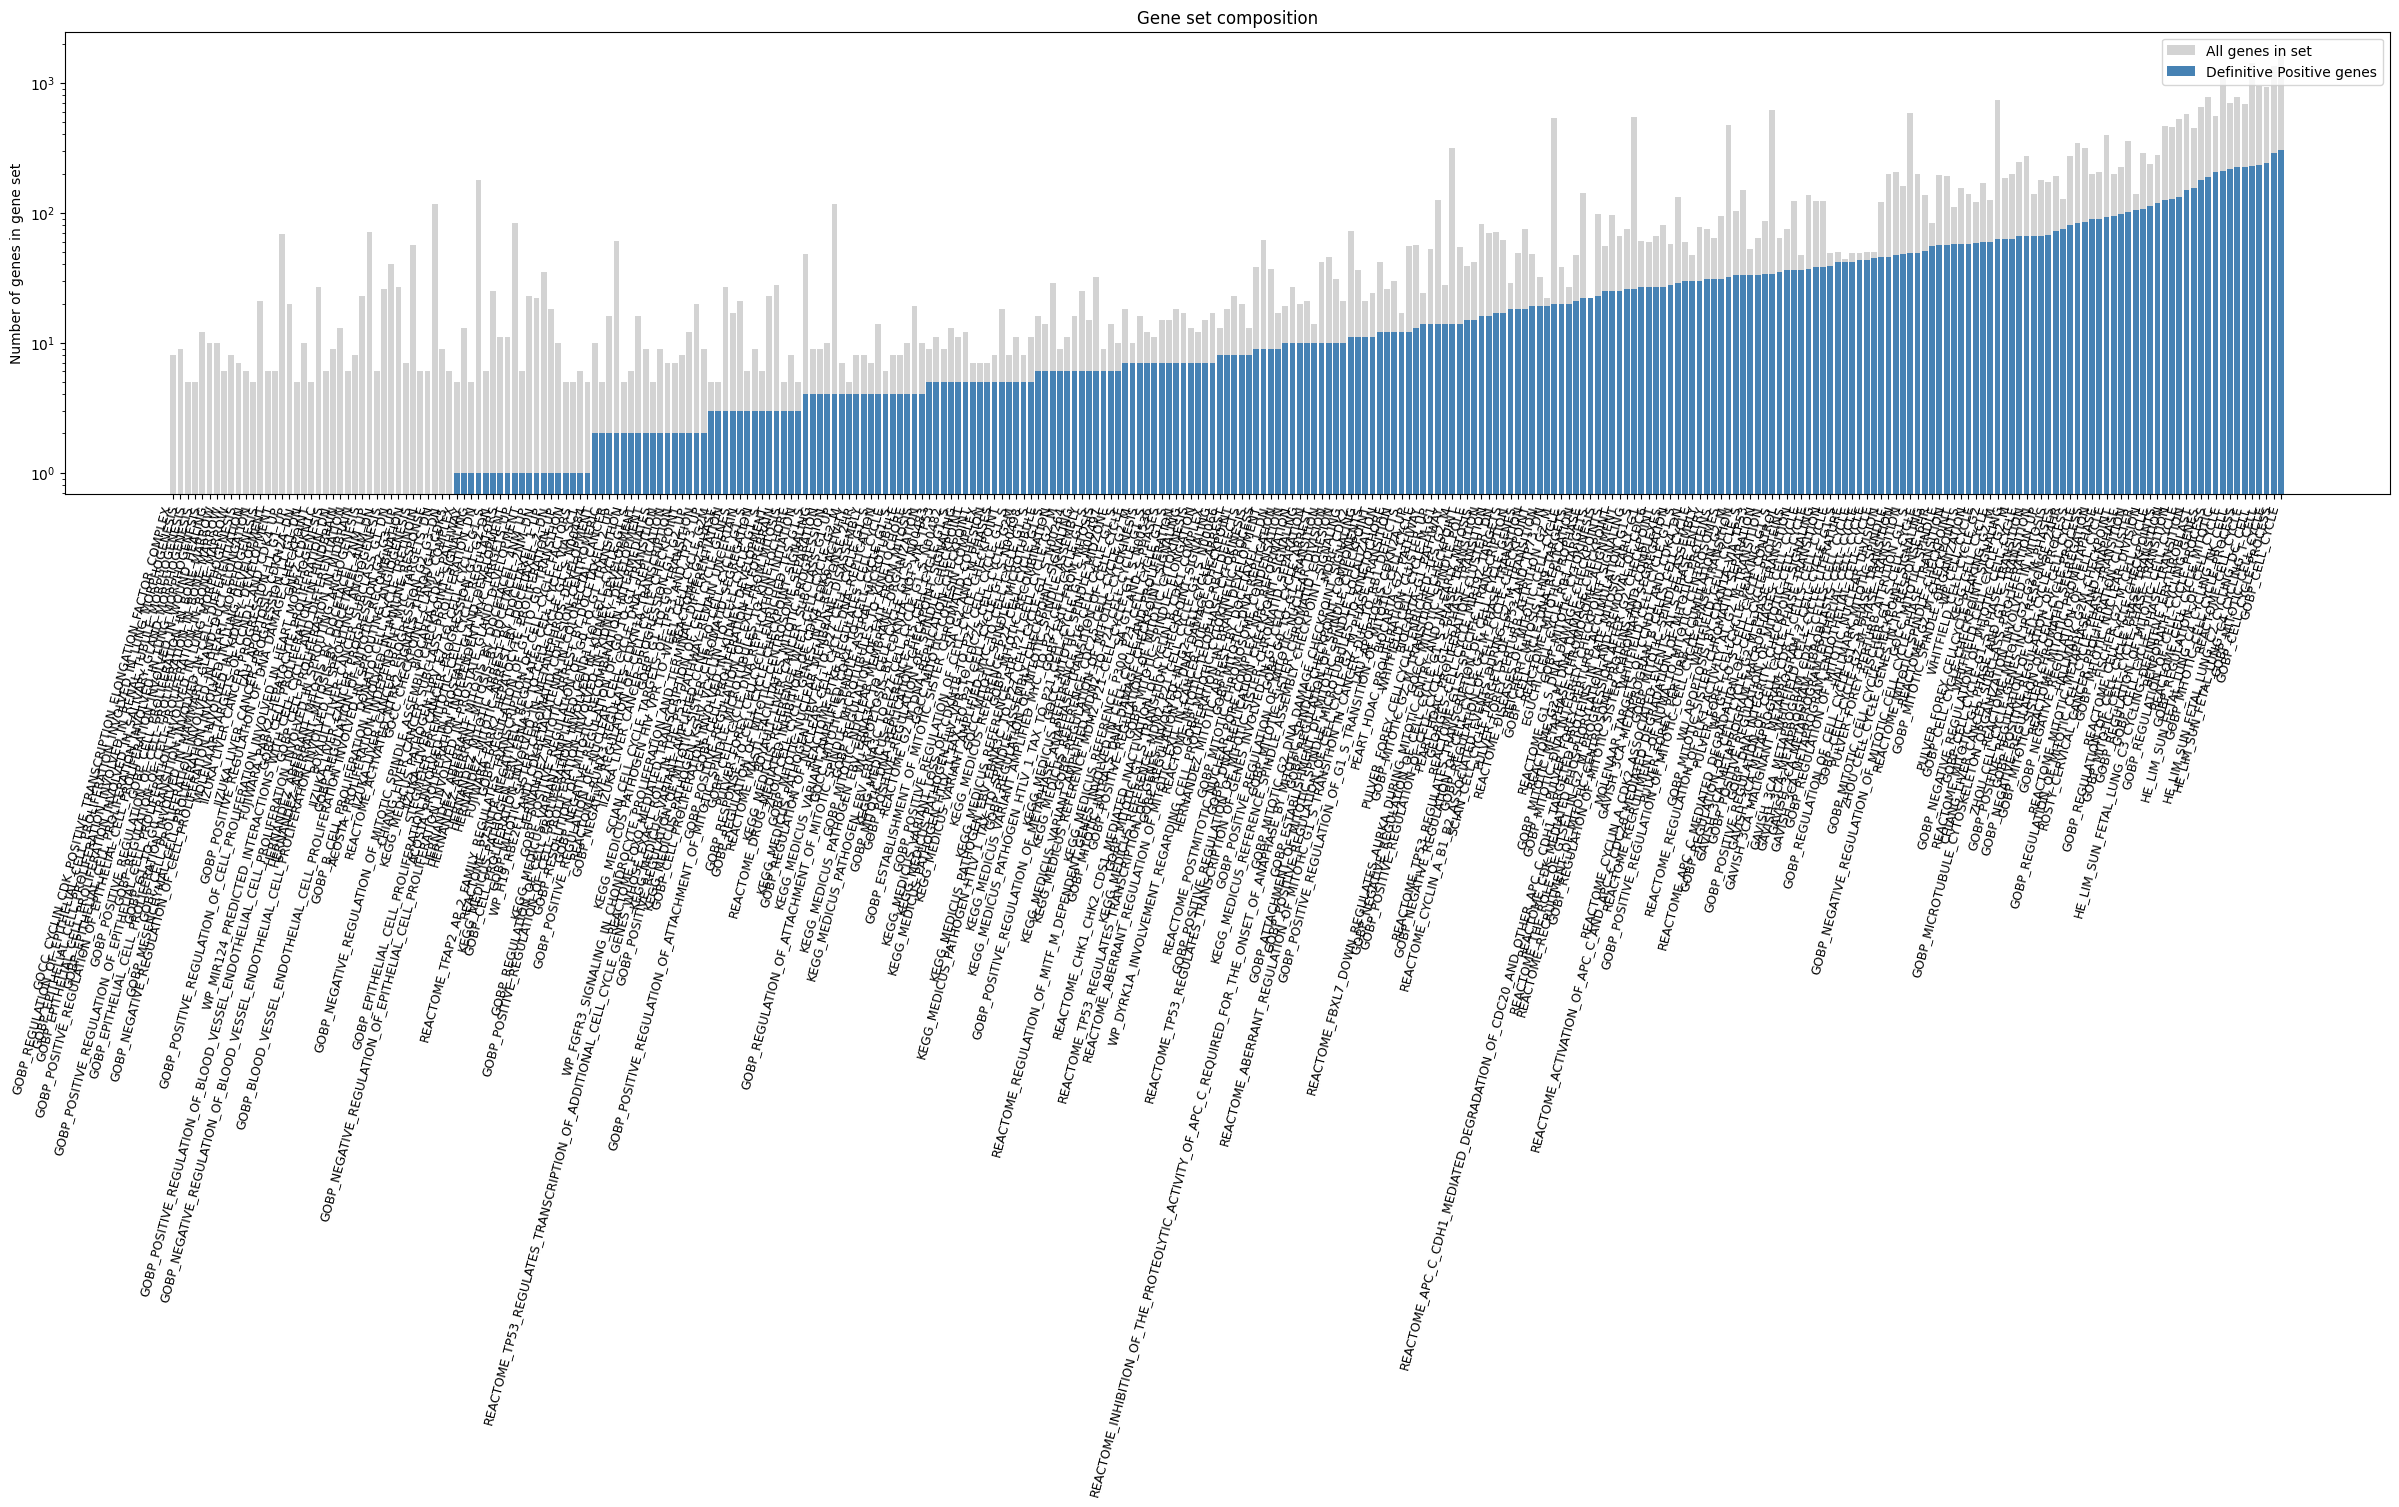

In [ ]:
# HOW MANY DEFINITIVE POSITIVE GENES IN ORIGINAL POSITIVE GENESTES

# Sort by significance (optional)
df_plot = df_genesets_positive.copy().sort_values("n_genes_positive")

# Create figure and axis
fig, ax = plt.subplots(figsize=(30, 6))

# Base layer: total genes
ax.bar(
    df_plot["set_name"],
    df_plot["n_genes"],
    color="lightgray",
    label="All genes in set",
)

# Overlay: positive genes
ax.bar(
    df_plot["set_name"],
    df_plot["n_genes_positive"],
    color="steelblue",
    label="Definitive Positive genes"
)

# Add labels and aesthetics
ax.set_xticks(range(len(df_plot["set_name"])))
ax.set_xticklabels(df_plot["set_name"], rotation=75, ha="right", fontsize=9)
ax.set_ylabel("Number of genes in gene set")
ax.set_title("Gene set composition")
ax.legend(loc="upper right")
ax.set_yscale("log")

plt.tight_layout()
plt.show()


In [ ]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
df_genesets_big = df_genesets[df_genesets.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*df_genesets_big["gene_list"]))
total_positive = len(set().union(*df_genesets_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = df_genesets_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_genesets_enriched = pd.concat([df_genesets_big, results], axis=1)
df_genesets_enriched = df_genesets_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_genesets_enriched["enrichment_pvalue_adj"] = multipletests(
    df_genesets_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_genesets_enriched["significant"] = df_genesets_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_genesets_enriched['significant'].sum()} / {len(df_genesets_enriched)}")
display(
    df_genesets_enriched[
        ["set_name", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_genesets_significant = df_genesets_enriched[df_genesets_enriched['significant'] == True]

Unique total genes: 43351
Unique total positive genes: 388

Significant enriched gene sets: 7994 / 35134


set_name  n_genes  \
39663             FIGAROL_EGFR_TKI_DRUG_TOLERANT_CELL_DN      495   
23424                  GOBP_MEIOSIS_I_CELL_CYCLE_PROCESS      142   
8470   GOCC_TRANSFERASE_COMPLEX_TRANSFERRING_PHOSPHOR...      310   
35041                       REACTOME_CELLULAR_SENESCENCE      197   
3778          GSE34205_HEALTHY_VS_RSV_INF_INFANT_PBMC_DN      200   
49753                                           MORF_DEK      264   
37981              MOLENAAR_TARGETS_OF_CCND1_AND_CDK4_DN       59   
4443                  GSE2128_C57BL6_VS_NOD_THYMOCYTE_UP      199   
5475   GSE16451_CTRL_VS_WEST_EQUINE_ENC_VIRUS_IMMATUR...      200   
38615                                    PID_E2F_PATHWAY       73   

       n_genes_positive  enrichment_prob  enrichment_pvalue  \
39663               198    2.578402e-290                0.0   
23424                30     2.327813e-32                0.0   
8470                 30     5.428911e-22                0.0   
35041                30     7.180237e-28                0.0   
3778                 30     1.143374e-27                0.0   
49753                30     4.950161e-24                0.0   
37981                30     5.331897e-46                0.0   
4443                 30     9.799980e-28                0.0   
5475                 30     1.143374e-27                0.0   
38615                30     2.239099e-42                0.0   

       enrichment_pvalue_adj  significant  
39663                    0.0         True  
23424                    0.0         True  
8470                     0.0         True  
35041                    0.0         True  
3778                     0.0         True  
49753                    0.0         True  
37981                    0.0         True  
4443                     0.0         True  
5475                     0.0         True  
38615                    0.0         True

Original gene sets: 291
Significantly enriched gene sets: 7994
Overlap (shared sets): 230

Original genesets that are enriched:


set_name  \
49                                     GOBP_CELL_CYCLE   
66                             GOBP_CELL_CYCLE_PROCESS   
44                             GOBP_MITOTIC_CELL_CYCLE   
290            HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_T_CELL   
287           HE_LIM_SUN_FETAL_LUNG_C2_CYCLING_DC_CELL   
..                                                 ...   
169       SCIAN_CELL_CYCLE_TARGETS_OF_TP53_AND_TP73_UP   
114  GOBP_CELL_PROLIFERATION_INVOLVED_IN_METANEPHRO...   
21   KEGG_MEDICUS_VARIANT_AMPLIFIED_CCND1_TO_CELL_C...   
112  GOBP_MITOTIC_SISTER_CHROMATID_COHESION_CENTROM...   
125  GOBP_REGULATION_OF_CELL_PROLIFERATION_INVOLVED...   

                                             gene_list  n_genes  \
49   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
66   [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
44   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   
290  [A1BG, AAAS, AARS1, ABHD12, ABI2, ACAD9, ACAT2...      939   
287  [AAAS, AARS1, AARS2, AASDH, ABCB7, ABCB8, ACAA...     1423   
..                                                 ...      ...   
169  [CDKN1A, GAS2L1, HRAS, JAG2, LTBP2, NEDD9, SEP...        9   
114  [BMP7, EGR1, GPC3, MYC, OSR1, PDGFRB, PTCH1, S...       10   
21                [CCND1, CDK4, E2F1, E2F2, E2F3, RB1]        6   
112                   [BOD1, BUB1, NAA10, NAA50, SGO1]        5   
125  [BMP4, BMP7, CFLAR, EGR1, FLCN, GATA3, IL6R, I...       16   

                                        genes_positive  n_genes_positive  \
49   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305   
66   [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287   
44   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241   
290  [ANAPC15, ARHGEF39, ARL6IP1, ASPM, ATAD2, ATAD...               231   
287  [ANAPC15, ARHGEF39, ASPM, ATAD2, ATAD5, AURKA,...               227   
..                                                 ...               ...   
169                                     [CDKN1A, TP53]                 2   
114                                      [EGR1, STAT1]                 2   
21                                        [CDK4, E2F1]                 2   
112                                      [BUB1, NAA10]                 2   
125                                      [CFLAR, EGR1]                 2   

     n_genes_ratio  
49        0.178886  
66        0.212908  
44        0.258861  
290       0.246006  
287       0.159522  
..             ...  
169       0.222222  
114       0.200000  
21        0.333333  
112       0.400000  
125       0.125000  

[230 rows x 6 columns]


Original genesets that are NOT enriched:


set_name  \
246      CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_DN   
176                BOYAULT_LIVER_CANCER_SUBCLASS_G1_UP   
255    ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN   
231    ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP   
165     HERNANDEZ_ABERRANT_MITOSIS_BY_DOCETACEL_2NM_UP   
..                                                 ...   
122  GOBP_NEGATIVE_REGULATION_OF_MITOTIC_SPINDLE_AS...   
26   KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE...   
2                        GOCC_CHECKPOINT_CLAMP_COMPLEX   
98   GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN...   
97   GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN...   

                                             gene_list  n_genes  \
246  [AADAC, AASS, ABAT, ABCA6, ABCA8, ABCB11, ABCB...      179   
176  [ABCC10, ABHD3, ADAR, ADGRG1, AHNAK, AHSA2P, A...      116   
255  [ACRV1, ACSM3, ADAM8, ADAMTSL4, ADGRE5, ADGRG1...      116   
231  [AATF, BLMH, CCNE1, CD320, CLUH, CRYBG2, CSE1L...       84   
165  [AGT, ARHGDIB, ASNS, BNC2, BTRC, CASP7, CD3D, ...       71   
..                                                 ...      ...   
122              [MAD1L1, MAD2L1BP, PRAP1, SKA1, SKA3]        5   
26                       [E2F1, E2F2, E2F3, RB1, SKP2]        5   
2                    [HUS1, HUS1B, RAD1, RAD9A, RAD9B]        5   
98                   [AREG, ESR1, MED1, TFAP2C, WNT5A]        5   
97                    [FGF10, FGFR2, NKX3-1, SHH, TNF]        5   

                genes_positive  n_genes_positive  n_genes_ratio  
246                     [RHOB]                 1       0.005587  
176  [DNAJC9, LBR, LMNA, RPA1]                 4       0.034483  
255                         []                 0       0.000000  
231                    [CCNE1]                 1       0.011905  
165                         []                 0       0.000000  
..                         ...               ...            ...  
122                     [SKA1]                 1       0.200000  
26                      [E2F1]                 1       0.200000  
2                      [RAD9A]                 1       0.200000  
98                          []                 0       0.000000  
97                          []                 0       0.000000  

[61 rows x 6 columns]

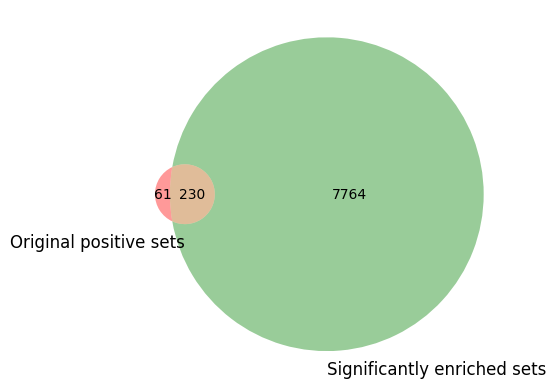

In [ ]:
# PLOT HOW MANY ORTIGNA PSTIVE GENESTES ARE ENRICHED BASED ON DEFINITVE POSTIVE GENS

# Define your sets
original_genesets = set(df_genesets_positive.set_name)
enriched_genesets = set(df_genesets_significant.set_name)
intersection_genesets = original_genesets & enriched_genesets
only_original_genesets = original_genesets - enriched_genesets
only_enriched_genesets = enriched_genesets - original_genesets

#  summary info
print(f"Original gene sets: {len(original_genesets)}")
print(f"Significantly enriched gene sets: {len(enriched_genesets)}")
print(f"Overlap (shared sets): {len(intersection_genesets)}")

print("\nOriginal genesets that are enriched:")
display(df_genesets_positive[df_genesets_positive.set_name.isin(intersection_genesets)])

print("\nOriginal genesets that are NOT enriched:")
display(df_genesets_positive[df_genesets_positive.set_name.isin(only_original_genesets)]
        .sort_values(by="n_genes", ascending=False))

# --- Visualization ---
venn2(
    subsets=(
        len(only_original_genesets),
        len(only_enriched_genesets),
        len(intersection_genesets)
    ),
    set_labels=('Original positive sets', 'Significantly enriched sets'),
)
